In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from cinnabar.plotting import _master_plot
from cinnabar.stats import bootstrap_statistic
import seaborn as sns
sns.set_theme()

In [103]:
# load the basic edge data
edge_data_openfe = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/combined_pymbar3_edge_data.csv")
fep_plus_edge_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/schrodinger_21_4_results/combined_schrodinger_ddg.csv")
fep_plus_dg_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/schrodinger_21_4_results/combined_schrodinger_dg.csv")
dg_data_openfe = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/combined_pymbar3_calculated_dg_data.csv")
# load the fixed pfkfb3 dataset
pfkfb3_edge_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/reruns/rerun_pymbar3_edge_data.csv")

In [104]:
#load the private data
private_raw_edge_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/private_processed_results/combined_pymbar3_edge_data.csv")

In [105]:
# manually drop pfkfb3 from the main df and add it from the rerun folder
# also drop edges marked as failed
complete_edges = edge_data_openfe[(edge_data_openfe["failed"] != True) & (edge_data_openfe["system name"] != "pfkfb3")].copy(deep=True).reset_index(drop=True)

all_openfe_edges = pd.concat([complete_edges, pfkfb3_edge_data])
# some ligands had missing exp data so drop differences involving those edges
all_openfe_edges = all_openfe_edges[all_openfe_edges["exp DDG (kcal/mol)"].notna()].copy(deep=True).reset_index(drop=True)
all_openfe_edges


,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_1_ligand_rmsd_max,complex_repeat_1_smallest_overlap,complex_repeat_2_DG (kcal/mol),complex_repeat_2_dDG (kcal/mol),complex_repeat_2_com_drift_max,complex_repeat_2_ligand_rmsd_max,complex_repeat_2_smallest_overlap,failed,system group,system name
0,34,25,0.670320,0,1.000000,0.057515,0.966424,0.730672,25,2,...,28.411707,0.110235,27.245596,0.113900,3.984440,4.468362,0.111000,NaN,charge_annihilation_set,cdk2
1,39charg,34,0.000000,-1,0.614286,0.012182,0.980239,0.988664,27,0,...,32.545681,0.207117,-21.401634,0.074439,31.848991,32.294037,0.206549,NaN,charge_annihilation_set,cdk2
2,39charg,25,0.000000,-1,0.614286,0.045757,0.985675,0.724526,25,2,...,29.240601,0.198225,17.934588,0.088183,31.980310,32.360592,0.198287,NaN,charge_annihilation_set,cdk2
3,17charg,8,0.223130,0,1.000000,0.143513,0.445382,0.996009,19,9,...,4.466974,0.022621,-3.680717,0.204893,3.250983,4.278775,0.022991,NaN,charge_annihilation_set,dlk
4,4charg,8,0.246597,0,1.000000,0.048722,0.579467,1.000000,20,3,...,3.812082,0.138050,4.873596,0.068123,3.571454,4.066833,0.134652,NaN,charge_annihilation_set,dlk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,49,47,0.860708,0,1.000000,0.074540,0.937613,0.653421,28,0,...,68.239609,0.098195,5.025639,0.083096,47.049469,68.496689,0.104164,NaN,merck,pfkfb3
1177,65,29,0.704688,0,1.000000,0.155796,0.895401,0.484258,30,0,...,67.026726,0.157674,-83.240725,0.102459,29.012836,53.727703,0.160825,NaN,merck,pfkfb3
1178,29,64,0.778801,0,1.000000,0.155630,0.895401,0.462020,30,1,...,54.050873,0.165275,86.337561,0.101216,46.250511,68.017464,0.164021,NaN,merck,pfkfb3
1179,47,46,0.548812,0,1.000000,0.202290,0.735485,0.305883,27,2,...,52.765472,0.133457,-11.214751,0.046477,43.071308,66.045006,0.131496,NaN,merck,pfkfb3


In [106]:
# load the dg data 
rerun_dg_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/reruns/rerun_pymbar3_calculated_dg_data.csv")
# get the combined dg data
dg_data_openfe = dg_data_openfe[(dg_data_openfe["system name"] != "pfkfb3") & (dg_data_openfe["Exp DG (kcal/mol)"].notna())].copy(deep=True).reset_index(drop=True)
all_dg_data = pd.concat([dg_data_openfe, rerun_dg_data])
all_dg_data

,ligand name,DG (kcal/mol),uncertainty (kcal/mol),Exp DG (kcal/mol),Exp dDG (kcal/mol),partner_id,dataset_name,system group,system name
0,34,-10.172449,0.117421,-9.880000,0.0,EliLilly,eli_lilly_charge/charge_annihilation_cdk2/resu...,charge_annihilation_set,cdk2
1,25,-9.867576,0.139560,-9.830000,0.0,EliLilly,eli_lilly_charge/charge_annihilation_cdk2/resu...,charge_annihilation_set,cdk2
2,39charg,-7.297475,0.136737,-8.370000,0.0,EliLilly,eli_lilly_charge/charge_annihilation_cdk2/resu...,charge_annihilation_set,cdk2
3,17charg,-10.296180,0.073111,-10.440000,0.0,NaN,charge_annhil_dlk/charge_annhil_dlk/results_data,charge_annihilation_set,dlk
4,8,-10.185925,0.086863,-10.510000,0.0,NaN,charge_annhil_dlk/charge_annhil_dlk/results_data,charge_annihilation_set,dlk
...,...,...,...,...,...,...,...,...,...
35,24,-7.502059,0.198432,-8.869909,0.0,NaN,NaN,merck,pfkfb3
36,33,-8.514623,0.186763,-8.606922,0.0,NaN,NaN,merck,pfkfb3
37,30_flip_b,-7.261508,0.201435,-9.198191,0.0,NaN,NaN,merck,pfkfb3
38,31,-9.492619,0.233194,-9.282473,0.0,NaN,NaN,merck,pfkfb3


In [107]:
# add the FEP+ data to the all_dg_data df
fep_ccc, fep_plus_error = [], []
for _, row in all_dg_data.iterrows():
    # find the matching row in the fep_plus_dg_data
    matching_ds = fep_plus_dg_data[(fep_plus_dg_data["system name"] == row["system name"]) & (fep_plus_dg_data["system group"] == row["system group"])]
    matching_row = matching_ds[matching_ds["Ligand name"] == row["ligand name"]].iloc[0]
    fep_ccc.append(matching_row["Pred. dG (kcal/mol)"])
    fep_plus_error.append(matching_row["Pred. dG std. error (kcal/mol)"])
    # make sure that the exp data is close 
    assert abs(matching_row["Exp. dG (kcal/mol)"] - row["Exp DG (kcal/mol)"]) < 0.1, f"Mismatch in exp data for {row['system name']} {row['ligand name']}"

# add back to the df
all_dg_data["FEP+ DG (kcal/mol)"] = fep_ccc
all_dg_data["FEP+ DG std. error (kcal/mol)"] = fep_plus_error


In [108]:
all_dg_data

,ligand name,DG (kcal/mol),uncertainty (kcal/mol),Exp DG (kcal/mol),Exp dDG (kcal/mol),partner_id,dataset_name,system group,system name,FEP+ DG (kcal/mol),FEP+ DG std. error (kcal/mol)
0,34,-10.172449,0.117421,-9.880000,0.0,EliLilly,eli_lilly_charge/charge_annihilation_cdk2/resu...,charge_annihilation_set,cdk2,-10.23,0.25
1,25,-9.867576,0.139560,-9.830000,0.0,EliLilly,eli_lilly_charge/charge_annihilation_cdk2/resu...,charge_annihilation_set,cdk2,-9.77,0.26
2,39charg,-7.297475,0.136737,-8.370000,0.0,EliLilly,eli_lilly_charge/charge_annihilation_cdk2/resu...,charge_annihilation_set,cdk2,-8.23,0.25
3,17charg,-10.296180,0.073111,-10.440000,0.0,NaN,charge_annhil_dlk/charge_annhil_dlk/results_data,charge_annihilation_set,dlk,-10.69,0.19
4,8,-10.185925,0.086863,-10.510000,0.0,NaN,charge_annhil_dlk/charge_annhil_dlk/results_data,charge_annihilation_set,dlk,-10.91,0.19
...,...,...,...,...,...,...,...,...,...,...,...
35,24,-7.502059,0.198432,-8.869909,0.0,NaN,NaN,merck,pfkfb3,-9.06,0.07
36,33,-8.514623,0.186763,-8.606922,0.0,NaN,NaN,merck,pfkfb3,-9.51,0.07
37,30_flip_b,-7.261508,0.201435,-9.198191,0.0,NaN,NaN,merck,pfkfb3,-8.98,0.07
38,31,-9.492619,0.233194,-9.282473,0.0,NaN,NaN,merck,pfkfb3,-9.45,0.07


In [8]:
import numpy as np
# calculate the pairwise DDG for each system
dg_system_metrics = []  
for system in all_dg_data["system group"].unique():
    # get the edges for these systems
    system_df = all_dg_data[all_dg_data["system group"] == system].copy(deep=True).reset_index(drop=True)
    targets = system_df["system name"].unique()
    for target in targets:
        # get the edges for this target
        target_df = system_df[(system_df["system name"] == target)].copy(deep=True).reset_index(drop=True)
        target_data = {"System": target, "Class": system, "N_ligs": len(target_df)}
        ligands = target_df["ligand name"].unique()
        # calculate the bootsrap metrics
        for prediction, error, label in [("DG (kcal/mol)", "uncertainty (kcal/mol)", "OpenFE"), ("FEP+ DG (kcal/mol)", "FEP+ DG std. error (kcal/mol)", "FEP+")]:
            exp_ddgs, exp_error, prediction_ddgs, prediction_error = [], [], [], []
            for i, ligand_a in enumerate(ligands):
                for j, ligand_b in enumerate(ligands):
                    if i >= j:
                        continue
                    # get the exp ddg for this pair
                    ligand_a_exp = target_df[target_df["ligand name"] == ligand_a]["Exp DG (kcal/mol)"].values[0]
                    ligand_b_exp = target_df[target_df["ligand name"] == ligand_b]["Exp DG (kcal/mol)"].values[0]
                    exp_ddg = ligand_b_exp - ligand_a_exp
                    exp_ddgs.append(exp_ddg)
                    exp_error_a = target_df[target_df["ligand name"] == ligand_a]["Exp dDG (kcal/mol)"].values[0]
                    exp_error_b = target_df[target_df["ligand name"] == ligand_b]["Exp dDG (kcal/mol)"].values[0]
                    exp_error.append((exp_error_a ** 2 + exp_error_b ** 2) ** 0.5)
                    # get the prediction ddg for this pair
                    ligand_a_pred = target_df[target_df["ligand name"] == ligand_a][prediction].values[0]
                    ligand_b_pred = target_df[target_df["ligand name"] == ligand_b][prediction].values[0]
                    prediction_ddg = ligand_b_pred - ligand_a_pred
                    prediction_ddgs.append(prediction_ddg)
                    prediction_error_a = target_df[target_df["ligand name"] == ligand_a][error].values[0]
                    prediction_error_b = target_df[target_df["ligand name"] == ligand_b][error].values[0]
                    prediction_error.append((prediction_error_a ** 2 + prediction_error_b ** 2) ** 0.5)
            # convert to numpy arrays
            exp = np.array(exp_ddgs)
            exp_error = np.array(exp_error)
            prediction = np.array(prediction_ddgs)
            prediction_error = np.array(prediction_error)
            # manual bootstrap the ddg values
            nbootstrap = 1000
            rmse = np.zeros(nbootstrap)
            for i in range(nbootstrap):
                # sample with replacement
                indices = np.random.choice(len(exp), size=len(exp), replace=True)
                sampled_exp = exp[indices]
                sampled_prediction = prediction[indices]
                # calculate the RMSE
                rmse[i] = np.sqrt(np.mean((sampled_prediction - sampled_exp) ** 2))
            # calculate the RMSE mean and CI
            s = {
                "mle": np.mean(rmse),
                "low": np.percentile(rmse, 2.5),
                "high": np.percentile(rmse, 97.5)
            }
            target_data[f"{label} RMSE"] = s["mle"]
            target_data[f"{label} RMSE_lower"] = s["low"]
            target_data[f"{label} RMSE_upper"] = s["high"]
        # add the data to a new dataframe
        dg_system_metrics.append(target_data)
# create a new dataframe with all of the metrics calculated for each system
dg_system_metrics = pd.DataFrame(dg_system_metrics)
dg_system_metrics.sort_values(by=['Class', 'OpenFE RMSE'], inplace=True)
dg_system_metrics
        

,System,Class,N_ligs,OpenFE RMSE,OpenFE RMSE_lower,OpenFE RMSE_upper,FEP+ RMSE,FEP+ RMSE_lower,FEP+ RMSE_upper
11,tyk2,charge_annihilation_set,5,0.629374,0.436188,0.821801,1.113777,0.683451,1.464824
1,dlk,charge_annihilation_set,5,0.886964,0.613233,1.149318,0.447592,0.318091,0.579496
0,cdk2,charge_annihilation_set,3,0.991475,0.254872,1.364974,0.357787,0.080001,0.490000
5,irak4_s3,charge_annihilation_set,4,1.024047,0.656027,1.322076,1.206342,0.727788,1.642056
4,irak4_s2,charge_annihilation_set,5,1.085697,0.690243,1.400539,1.245636,0.839668,1.645513
3,ephx2,charge_annihilation_set,4,1.107018,0.741251,1.529852,1.208019,0.794635,1.633386
6,itk,charge_annihilation_set,4,1.205747,0.739634,1.684054,1.039182,0.614288,1.440885
7,jak1,charge_annihilation_set,6,1.247855,0.931646,1.575351,0.698604,0.473865,0.910160
10,thrombin,charge_annihilation_set,6,1.424093,1.037526,1.792047,1.444741,0.998834,1.883723
2,egfr,charge_annihilation_set,5,1.954771,1.337348,2.538326,1.185020,0.850396,1.493318


In [9]:
# how many systems have RMSE with openfe less that 1 kcal/mol compared to FEP+?
openfe_less_than_1 = dg_system_metrics[dg_system_metrics["OpenFE RMSE"] < 1].copy(deep=True).reset_index(drop=True)
fep_plus_less_than_1 = dg_system_metrics[dg_system_metrics["FEP+ RMSE"] < 1].copy(deep=True).reset_index(drop=True)
print(f"Number of systems with OpenFE RMSE < 1 kcal/mol: {len(openfe_less_than_1)}")
print(f"Number of systems with FEP+ RMSE < 1 kcal/mol: {len(fep_plus_less_than_1)}")

Number of systems with OpenFE RMSE < 1 kcal/mol: 11
Number of systems with FEP+ RMSE < 1 kcal/mol: 19


In [10]:
# calculate the weighted RMSE for OpenFE and FEP+ with 95% CI from bootstrapping add to the dataframe
import numpy as np
nboots = 1000
openfe_rmse, fep_plus_rmse = np.zeros(nboots), np.zeros(nboots)
for i in range(nboots):
    # bootstrap the data
    bootstrapped_data = dg_system_metrics.sample(n=len(dg_system_metrics), replace=True)
    openfe_rmse[i] = np.sqrt(np.sum(bootstrapped_data["OpenFE RMSE"] ** 2 * bootstrapped_data["N_ligs"]) / np.sum(bootstrapped_data["N_ligs"]))
    fep_plus_rmse[i] = np.sqrt(np.sum(bootstrapped_data["FEP+ RMSE"] ** 2 * bootstrapped_data["N_ligs"]) / np.sum(bootstrapped_data["N_ligs"]))
    

row_data = {
    "System": "Weighted\nRMSE",
    "Class": "Overall",
    "N_ligs": len(dg_system_metrics),
    "OpenFE RMSE": np.mean(openfe_rmse),
    "OpenFE RMSE_lower": np.percentile(openfe_rmse, 2.5),
    "OpenFE RMSE_upper": np.percentile(openfe_rmse, 97.5),
    "FEP+ RMSE": np.mean(fep_plus_rmse),
    "FEP+ RMSE_lower": np.percentile(fep_plus_rmse, 2.5),
    "FEP+ RMSE_upper": np.percentile(fep_plus_rmse, 97.5)
}
# add the row to the dataframe using concat
dg_system_metrics = pd.concat([dg_system_metrics, pd.DataFrame([row_data])], ignore_index=True)
dg_system_metrics

,System,Class,N_ligs,OpenFE RMSE,OpenFE RMSE_lower,OpenFE RMSE_upper,FEP+ RMSE,FEP+ RMSE_lower,FEP+ RMSE_upper
0,tyk2,charge_annihilation_set,5,0.629374,0.436188,0.821801,1.113777,0.683451,1.464824
1,dlk,charge_annihilation_set,5,0.886964,0.613233,1.149318,0.447592,0.318091,0.579496
2,cdk2,charge_annihilation_set,3,0.991475,0.254872,1.364974,0.357787,0.080001,0.490000
3,irak4_s3,charge_annihilation_set,4,1.024047,0.656027,1.322076,1.206342,0.727788,1.642056
4,irak4_s2,charge_annihilation_set,5,1.085697,0.690243,1.400539,1.245636,0.839668,1.645513
5,ephx2,charge_annihilation_set,4,1.107018,0.741251,1.529852,1.208019,0.794635,1.633386
6,itk,charge_annihilation_set,4,1.205747,0.739634,1.684054,1.039182,0.614288,1.440885
7,jak1,charge_annihilation_set,6,1.247855,0.931646,1.575351,0.698604,0.473865,0.910160
8,thrombin,charge_annihilation_set,6,1.424093,1.037526,1.792047,1.444741,0.998834,1.883723
9,egfr,charge_annihilation_set,5,1.954771,1.337348,2.538326,1.185020,0.850396,1.493318


In [11]:
# paired significance test on the RMSE values not including the weighted RMSE
from scipy.stats import ttest_rel
# filter out the weighted RMSE row
dg_system_metrics_filtered = dg_system_metrics[dg_system_metrics["System"] != "Weighted\nRMSE"].copy(deep=True).reset_index(drop=True)
# perform the wilcoxon signed-rank test
from scipy.stats import wilcoxon
stat, p_value = wilcoxon(dg_system_metrics_filtered["OpenFE RMSE"], dg_system_metrics_filtered["FEP+ RMSE"])
print(f"Paired wilcoxon test between OpenFE and FEP+ RMSE: statistic = {stat:.3f}, p-value = {p_value}")

Paired wilcoxon test between OpenFE and FEP+ RMSE: statistic = 179.000, p-value = 1.6259146249455844e-07


In [12]:
# report the range of the RMSE values for OpenFE and FEP+ not including the weighted RMSE
openfe_rmse_range = dg_system_metrics_filtered["OpenFE RMSE"].agg(["min", "max"])
fep_plus_rmse_range = dg_system_metrics_filtered["FEP+ RMSE"].agg(["min", "max"])
print(f"OpenFE RMSE range: {openfe_rmse_range['min']:.3f} - {openfe_rmse_range['max']:.3f} kcal/mol")
print(f"FEP+ RMSE range: {fep_plus_rmse_range['min']:.3f} - {fep_plus_rmse_range['max']:.3f} kcal/mol")

OpenFE RMSE range: 0.629 - 4.911 kcal/mol
FEP+ RMSE range: 0.350 - 1.828 kcal/mol


{'Overall': 60, 'charge_annihilation_set': 12, 'fragments': 21, 'jacs_set': 29, 'janssen_bace': 33, 'mcs_docking_set': 35, 'merck': 43, 'miscellaneous_set': 48, 'scaffold_hopping_set': 50, 'water_set': 58}


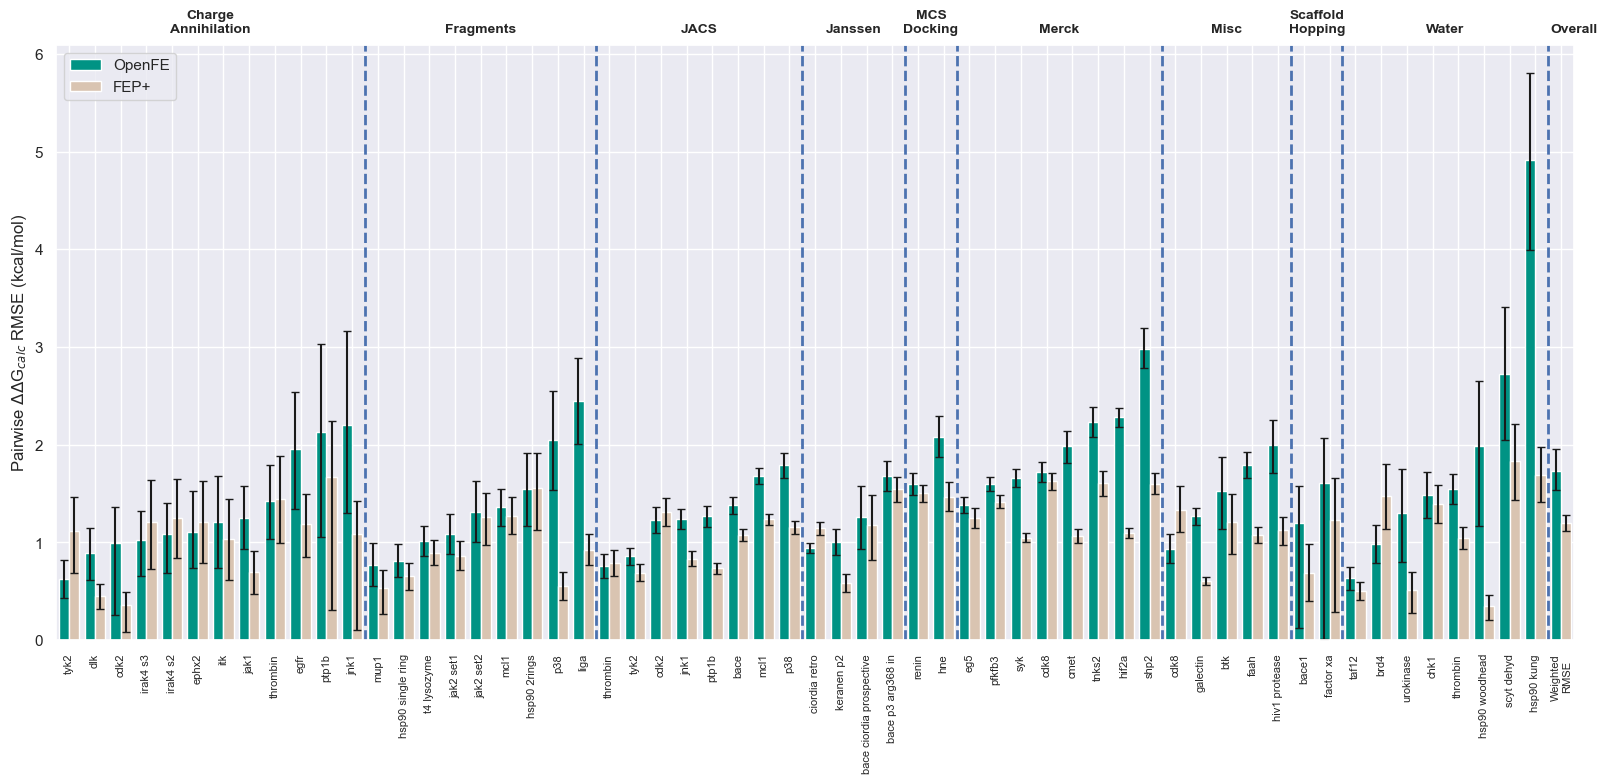

In [13]:
# plot the pairwise RMSE for OpenFE and FEP+ with 95% CI for each system and the weighted RMSE
x = np.arange(len(dg_system_metrics))

# Set up the figure
fig, ax = plt.subplots(figsize=(16, 8))
bar_width = 0.4

# Plot bars with error bars
rmse_err_openfe = [dg_system_metrics['OpenFE RMSE'] - dg_system_metrics['OpenFE RMSE_lower'], dg_system_metrics['OpenFE RMSE_upper'] - dg_system_metrics['OpenFE RMSE']]
rmse_err_plus = [dg_system_metrics['FEP+ RMSE'] - dg_system_metrics['FEP+ RMSE_lower'], dg_system_metrics['FEP+ RMSE_upper'] - dg_system_metrics['FEP+ RMSE']]
# "OpenFE": "#009384", "FEP+": "#d9c4b1"
ax.bar(x - bar_width/2, dg_system_metrics['OpenFE RMSE'], yerr=rmse_err_openfe, width=bar_width, label='OpenFE',
       color='#009384', capsize=3)
ax.bar(x + bar_width/2, dg_system_metrics['FEP+ RMSE'], yerr=rmse_err_plus, width=bar_width, label='FEP+',
       color="#d9c4b1", capsize=3)

# Set labels and ticks
ax.set_xticks(x)
names = dg_system_metrics['System'].str.replace("_", " ")
ax.set_xticklabels(names, rotation=90, fontsize=8)
ax.set_ylabel(r"Pairwise $\Delta\Delta$G$_{calc}$ RMSE (kcal/mol)")
# ax.set_title("Per-System RMSE and MUE with 95% Confidence Intervals")
ax.legend()

# Add colored background for classes
unique_classes = dg_system_metrics['Class'].unique()
# remove overall from the unique classes and add it to the end
unique_classes = [cls for cls in unique_classes if cls != "Overall"]
unique_classes.append("Overall")
class_bounds = dg_system_metrics.groupby('Class').size().cumsum().to_dict()
# move overall to the end
class_bounds["Overall"] = len(dg_system_metrics) + 1

for cls, bound in class_bounds.items():
    if cls == "Overall":
        continue
    class_bounds[cls] = bound - 1  # Adjust to match the last index of the class
print(class_bounds)
class_start = 0

colors = sns.color_palette("colorblind", len(unique_classes))
class_conversion = {"bayer_macrocycles": "Bayer\nMacrocycles", "charge_annihilation_set": "Charge\nAnnihilation", "fragments": "Fragments", "jacs_set": "JACS", "janssen_bace": "Janssen", "merck": "Merck", "miscellaneous_set": "Misc", "scaffold_hopping_set": "Scaffold\nHopping", "water_set": "Water", "mcs_docking_set": "MCS\nDocking"}
for i, cls in enumerate(unique_classes):
    cls_name = class_conversion.get(cls, cls)
    end = class_bounds[cls]
    # add dashed lines for the span but not the fill
    if cls != "charge_annihilation_set":
        ax.axvline(class_start - 0.5, linestyle='--', linewidth=2)
#     ax.axvspan(class_start - 0.5, end - 0.5, facecolor=colors[i], alpha=0.2)
    center = (class_start + end - 1) / 2
    ax.text(center, ax.get_ylim()[1] + 0.1, cls_name, ha='center', va='bottom', fontsize=10, weight='bold')
    class_start = end

plt.tight_layout()
plt.xlim(-0.5, len(dg_system_metrics) - 0.5)
plt.savefig("per_system_pairwise_rmse_openfe_vs_plus.png", dpi=300, bbox_inches='tight')

In [109]:
# make a new dataframe with all possible pairwise DDG values for openfe and fep+ with symmetry
all_pairwise_ddgs = []
for system in all_dg_data["system group"].unique():
    # get the edges for these systems
    system_df = all_dg_data[all_dg_data["system group"] == system].copy(deep=True).reset_index(drop=True)
    targets = system_df["system name"].unique()
    for target in targets:
        # get the edges for this target
        target_df = system_df[(system_df["system name"] == target)].copy(deep=True).reset_index(drop=True)
        # get the ligands
        ligands = target_df["ligand name"].unique()
        for i, ligand1 in enumerate(ligands):
            for j, ligand2 in enumerate(ligands):
                if i >= j:  # skip self-comparisons
                    continue
                # get the ddg values for these ligands
                exp_dg1 = target_df[target_df["ligand name"] == ligand1]["Exp DG (kcal/mol)"].values[0]
                exp_dg2 = target_df[target_df["ligand name"] == ligand2]["Exp DG (kcal/mol)"].values[0]
                openfe_dg1 = target_df[target_df["ligand name"] == ligand1]["DG (kcal/mol)"].values[0]
                openfe_dg2 = target_df[target_df["ligand name"] == ligand2]["DG (kcal/mol)"].values[0]
                fep_plus_ddg1 = target_df[target_df["ligand name"] == ligand1]["FEP+ DG (kcal/mol)"].values[0]
                fep_plus_ddg2 = target_df[target_df["ligand name"] == ligand2]["FEP+ DG (kcal/mol)"].values[0]
                # add to a new dataframe
                new_row = {
                    "System": target,
                    "Class": system,
                    "Ligand 1": ligand1,
                    "Ligand 2": ligand2,
                    "Exp DDG (kcal/mol)": exp_dg2 - exp_dg1,
                    "OpenFE DDG (kcal/mol)": openfe_dg2 - openfe_dg1,
                    "FEP+ DDG (kcal/mol)": fep_plus_ddg2 - fep_plus_ddg1,
                }
                all_pairwise_ddgs.append(new_row)
all_pairwise_ddgs = pd.DataFrame(all_pairwise_ddgs)
all_pairwise_ddgs

,System,Class,Ligand 1,Ligand 2,Exp DDG (kcal/mol),OpenFE DDG (kcal/mol),FEP+ DDG (kcal/mol)
0,cdk2,charge_annihilation_set,34,25,0.050000,0.304872,0.459999
1,cdk2,charge_annihilation_set,34,39charg,1.510000,2.874974,2.000000
2,cdk2,charge_annihilation_set,25,39charg,1.460000,2.570102,1.540001
3,dlk,charge_annihilation_set,17charg,8,-0.070001,0.110256,-0.220000
4,dlk,charge_annihilation_set,17charg,18,0.460000,-0.090194,0.650000
...,...,...,...,...,...,...,...
10127,urokinase,water_set,"10302 (1GJ7, no water pose)",8696 (no water pose),1.020183,3.057647,1.250000
10128,urokinase,water_set,"10302 (1GJ7, no water pose)",7806 (no water pose),2.170857,3.103786,2.080000
10129,urokinase,water_set,11417 (no water pose),8696 (no water pose),0.763436,0.950458,0.260000
10130,urokinase,water_set,11417 (no water pose),7806 (no water pose),1.914111,0.996598,1.090000


Probability of OpenFE being below 1 kcal/mol: 47.36%
Probability of FEP+ being below 1 kcal/mol: 60.69%
Probability of OpenFE being below 2 kcal/mol: 78%
Probability of FEP+ being below 2 kcal/mol: 90%


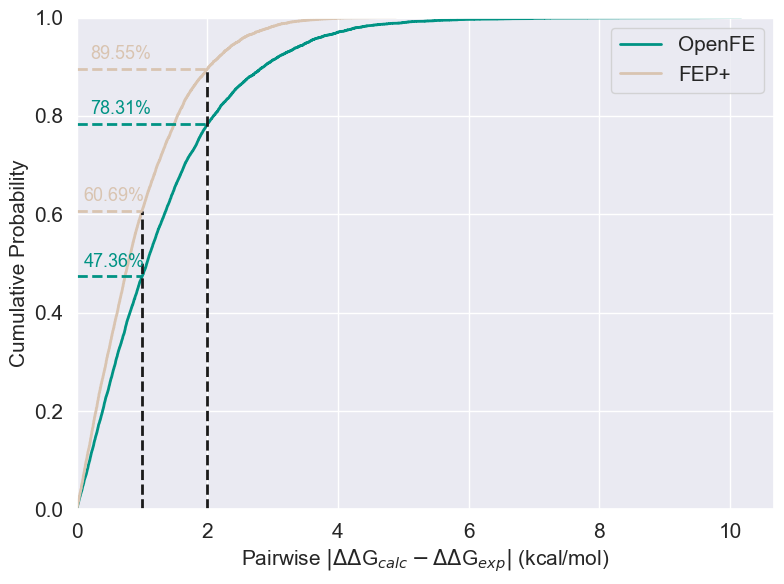

In [15]:
# plot ecdfs for openfe and fep+ ddg absolute errors
fig, ax = plt.subplots(figsize=(8, 6))
openfe_abs_ddg = np.abs(all_pairwise_ddgs["OpenFE DDG (kcal/mol)"] - all_pairwise_ddgs["Exp DDG (kcal/mol)"])
fep_plus_abs_ddg = np.abs(all_pairwise_ddgs["FEP+ DDG (kcal/mol)"] - all_pairwise_ddgs["Exp DDG (kcal/mol)"])
sns.ecdfplot(data=openfe_abs_ddg, ax=ax, label="OpenFE", color="#009384", linewidth=2)
sns.ecdfplot(data=fep_plus_abs_ddg, ax=ax, label="FEP+", color="#d9c4b1", linewidth=2)
# calculate the probability of being below 1 kcal/mol for both
prob_below_1_openfe = np.sum(openfe_abs_ddg < 1) / len(openfe_abs_ddg)
prob_below_1_fep_plus = np.sum(fep_plus_abs_ddg < 1) / len(fep_plus_abs_ddg)
print(f"Probability of OpenFE being below 1 kcal/mol: {prob_below_1_openfe:.2%}")
print(f"Probability of FEP+ being below 1 kcal/mol: {prob_below_1_fep_plus:.2%}")
# add a line at 1 kcal/mol for both
ax.axvline(x=1, ymax=prob_below_1_fep_plus, color='k', linestyle='--', linewidth=2)
ax.plot([0, 1], [prob_below_1_openfe, prob_below_1_openfe], color='#009384', linestyle='--', linewidth=2)
ax.plot([0, 1], [prob_below_1_fep_plus, prob_below_1_fep_plus], color='#d9c4b1', linestyle='--', linewidth=2)
# add a label above the line
ax.text(0.1, prob_below_1_openfe + 0.02, f"{prob_below_1_openfe:.2%}", color='#009384', fontsize=13)
ax.text(0.1, prob_below_1_fep_plus + 0.02, f"{prob_below_1_fep_plus:.2%}", color='#d9c4b1', fontsize=13)
# same again for 2  kcal/mol
prob_below_2_openfe = np.sum(openfe_abs_ddg < 2) / len(openfe_abs_ddg)
prob_below_2_fep_plus = np.sum(fep_plus_abs_ddg < 2) / len(fep_plus_abs_ddg)
print(f"Probability of OpenFE being below 2 kcal/mol: {prob_below_2_openfe:.0%}")
print(f"Probability of FEP+ being below 2 kcal/mol: {prob_below_2_fep_plus:.0%}")
# stop the line at the higher probability curve 

ax.axvline(x=2, ymax=prob_below_2_fep_plus, color='k', linestyle='--', linewidth=2)
ax.plot([0, 2], [prob_below_2_openfe, prob_below_2_openfe], color='#009384', linestyle='--', linewidth=2)
ax.plot([0, 2], [prob_below_2_fep_plus, prob_below_2_fep_plus], color='#d9c4b1', linestyle='--', linewidth=2)
# add a label above the line
ax.text(0.2, prob_below_2_openfe + 0.02, f"{prob_below_2_openfe:.2%}", color='#009384', fontsize=13)
ax.text(0.2, prob_below_2_fep_plus + 0.02, f"{prob_below_2_fep_plus:.2%}", color='#d9c4b1', fontsize=13)
# set the x and y labels
ax.set_xlabel(r"Pairwise $|\Delta\Delta$G$_{calc}-\Delta\Delta$G$_{exp}|$ (kcal/mol)", fontdict={"fontsize": 15})
ax.set_ylabel("Cumulative Probability", fontdict={"fontsize": 15})
# set x and y tick font size
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.xlim(left=0)
plt.legend(prop={"size": 15})
plt.tight_layout()
# save the figure
plt.savefig("ecdf_pairwise_abs_ddg_error_opnfe_vs_fep_plus.png", dpi=300, bbox_inches='tight')

In [16]:
# bin the absolute experimental DDG values in 1 kcal/mol bins 
# calculate the probability of gettting the sign of the DDG correct with openfe and fep+ for each bin
def bin_sign_correctness(data, bin_size=1.0):
    # get the absolute experimental DDG values
    data['abs_exp_ddg'] = np.abs(data['Exp DDG (kcal/mol)'])
    # max value value to work out the bins
    max_value = data['abs_exp_ddg'].max()
    bins = np.arange(0, max_value + bin_size, bin_size)
    
    # Bin the data
    data['bin'] = pd.cut(data['abs_exp_ddg'], bins=bins, right=False)
    
    # Calculate probabilities
    results = []
    # sort the bins by the lower edge
    for b in sorted(data['bin'].unique(), key=lambda x: x.left):
        subset = data[data['bin'] == b]
        if len(subset) == 0:
            continue
        # Calculate the probability of correct sign for OpenFE and FEP+ and bootstrap the results
        openfe_correct = np.sum(np.sign(subset['OpenFE DDG (kcal/mol)']) == np.sign(subset['Exp DDG (kcal/mol)']))
        fep_plus_correct = np.sum(np.sign(subset['FEP+ DDG (kcal/mol)']) == np.sign(subset['Exp DDG (kcal/mol)']))
        total = len(subset)
        # Bootstrap the probabilities
        nboots = 1000
        openfe_probs = []
        fep_plus_probs = [] 
        for _ in range(nboots):
            bootstrapped_subset = subset.sample(n=len(subset), replace=True)
            openfe_correct_boot = np.sum(np.sign(bootstrapped_subset['OpenFE DDG (kcal/mol)']) == np.sign(bootstrapped_subset['Exp DDG (kcal/mol)']))
            fep_plus_correct_boot = np.sum(np.sign(bootstrapped_subset['FEP+ DDG (kcal/mol)']) == np.sign(bootstrapped_subset['Exp DDG (kcal/mol)']))
            total_boot = len(bootstrapped_subset)
            openfe_probs.append(openfe_correct_boot / total_boot)
            fep_plus_probs.append(fep_plus_correct_boot / total_boot)
        # Calculate mean and 95% CI
        openfe_mean = np.mean(openfe_probs)
        openfe_low = np.percentile(openfe_probs, 2.5)
        openfe_high = np.percentile(openfe_probs, 97.5)
        fep_plus_mean = np.mean(fep_plus_probs)
        fep_plus_low = np.percentile(fep_plus_probs, 2.5)
        fep_plus_high = np.percentile(fep_plus_probs, 97.5)
        # store the results so we can use hue to split the data
        results.append({
            'bin': b.left,
            'OpenFE Probability': openfe_mean,
            'OpenFE Probability Lower': openfe_low,
            'OpenFE Probability Upper': openfe_high,
            'FEP+ Probability': fep_plus_mean,
            'FEP+ Probability Lower': fep_plus_low,
            'FEP+ Probability Upper': fep_plus_high
        })
        # x+=1
    return pd.DataFrame(results)
# Calculate the binned probabilities
binned_probabilities = bin_sign_correctness(all_pairwise_ddgs, bin_size=0.5)

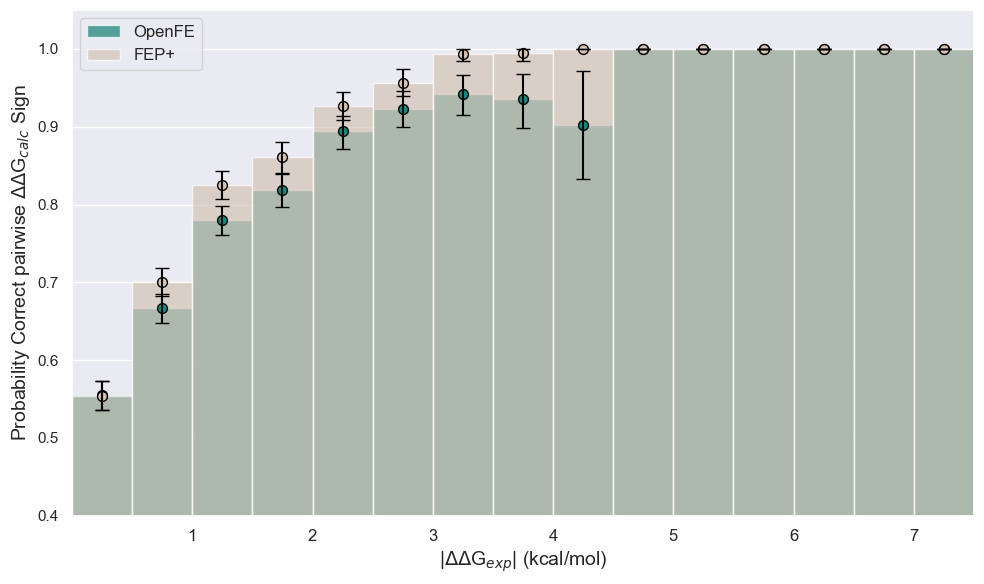

In [17]:

# Plot the binned probabilities using a bar plot with error bars
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=binned_probabilities, x='bin', y='OpenFE Probability', ax=ax, color='#009384', label='OpenFE', alpha=0.7, width=1.0)
sns.barplot(data=binned_probabilities, x='bin', y='FEP+ Probability', ax=ax, color='#d9c4b1', label='FEP+', alpha=0.7, width=1.0)
# add error bars for the probabilities
ax.set_xlabel(r"|$\Delta\Delta$G$_{exp}$| (kcal/mol)", fontsize=14)
ax.set_ylabel(r"Probability Correct pairwise $\Delta\Delta$G$_{calc}$ Sign", fontsize=14)
# set the x ticks to go from 0 to the max bin value in 1 kcal/mol increments
x_ticks = np.arange(1.5, 15.5, 2)
ax.errorbar(binned_probabilities['bin'] *2, binned_probabilities['OpenFE Probability'],
            yerr=[binned_probabilities['OpenFE Probability'] - binned_probabilities['OpenFE Probability Lower'],
                  binned_probabilities['OpenFE Probability Upper'] - binned_probabilities['OpenFE Probability']],
            fmt='none', color='black', capsize=5)
ax.errorbar(binned_probabilities['bin'] *2, binned_probabilities['FEP+ Probability'],
            yerr=[binned_probabilities['FEP+ Probability'] - binned_probabilities['FEP+ Probability Lower'],
                  binned_probabilities['FEP+ Probability Upper'] - binned_probabilities['FEP+ Probability']],
            fmt='none', color='black', capsize=5)
# add scatter points for the probabilities
ax.scatter(binned_probabilities['bin'] *2, binned_probabilities['OpenFE Probability'], color='#009384', edgecolor='black', s=50)
ax.scatter(binned_probabilities['bin'] *2, binned_probabilities['FEP+ Probability'], color='#d9c4b1', edgecolor='black', s=50)
# print(x_ticks)
# print(ax.get_xticks())
ax.set_xticks(x_ticks)
ax.set_xticklabels([1, 2, 3, 4, 5, 6, 7], fontsize=12)
plt.xlim((-0.5,14.5))
# save the figure
plt.legend(fontsize=12)
plt.tight_layout()
plt.ylim(bottom=0.4)
plt.savefig("binned_sign_correctness_openfe_vs_fep_plus.png", dpi=300, bbox_inches='tight')

In [18]:
all_pairwise_ddgs

,System,Class,Ligand 1,Ligand 2,Exp DDG (kcal/mol),OpenFE DDG (kcal/mol),FEP+ DDG (kcal/mol),abs_exp_ddg,bin
0,cdk2,charge_annihilation_set,34,25,0.050000,0.304872,0.459999,0.050000,"[0.0, 0.5)"
1,cdk2,charge_annihilation_set,34,39charg,1.510000,2.874974,2.000000,1.510000,"[1.5, 2.0)"
2,cdk2,charge_annihilation_set,25,39charg,1.460000,2.570102,1.540001,1.460000,"[1.0, 1.5)"
3,dlk,charge_annihilation_set,17charg,8,-0.070001,0.110256,-0.220000,0.070001,"[0.0, 0.5)"
4,dlk,charge_annihilation_set,17charg,18,0.460000,-0.090194,0.650000,0.460000,"[0.0, 0.5)"
...,...,...,...,...,...,...,...,...,...
10127,urokinase,water_set,"10302 (1GJ7, no water pose)",8696 (no water pose),1.020183,3.057647,1.250000,1.020183,"[1.0, 1.5)"
10128,urokinase,water_set,"10302 (1GJ7, no water pose)",7806 (no water pose),2.170857,3.103786,2.080000,2.170857,"[2.0, 2.5)"
10129,urokinase,water_set,11417 (no water pose),8696 (no water pose),0.763436,0.950458,0.260000,0.763436,"[0.5, 1.0)"
10130,urokinase,water_set,11417 (no water pose),7806 (no water pose),1.914111,0.996598,1.090000,1.914111,"[1.5, 2.0)"


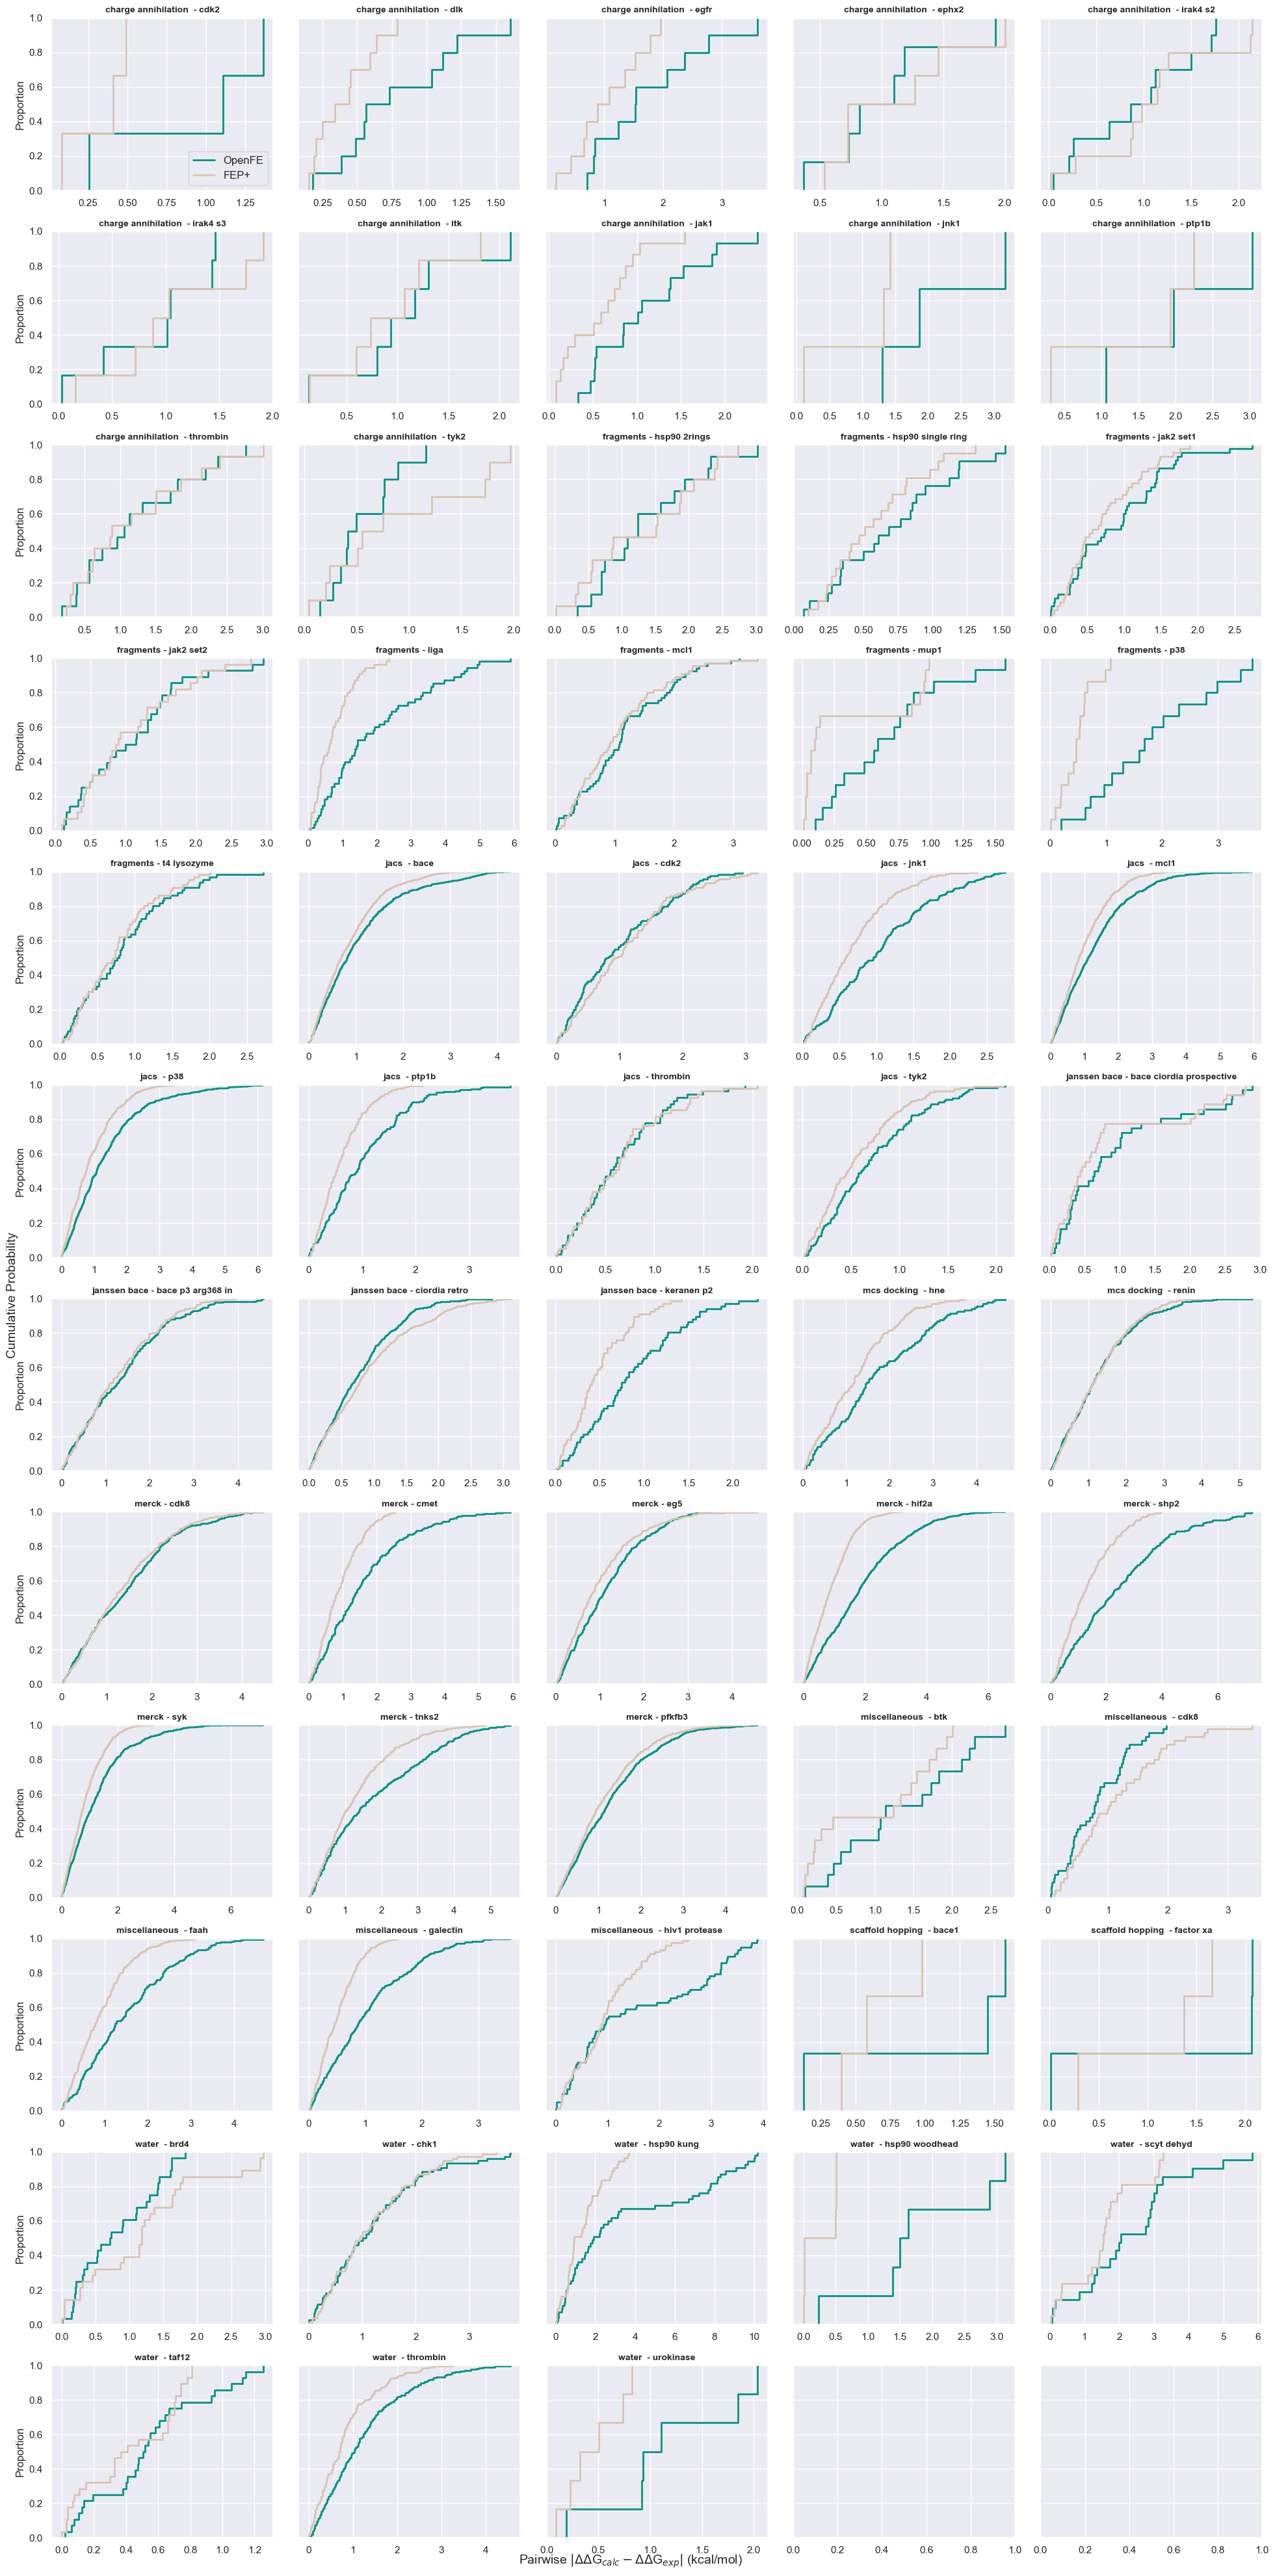

In [19]:
# make a 12x5 grid of subplots with shared y axis and compare the openfe and fep absolute errors using ecdfs for each system name
fig, axs = plt.subplots(12, 5, figsize=(20, 40), sharey=True)
# Flatten the axes array for easier iteration
axs = axs.flatten()
i=0
# Loop through each system and plot the data  
system_groups = all_pairwise_ddgs["Class"].unique()
for system in system_groups:
    system_df = all_pairwise_ddgs[all_pairwise_ddgs["Class"] == system].copy(deep=True).reset_index(drop=True)
    # get the unique target names
    target_names = system_df["System"].unique()    
    for target in target_names:
        # get the edges for this target
        target_df = system_df[system_df["System"] == target].copy(deep=True).reset_index(drop=True)
        # calculate the absolute errors
        openfe_abs_ddg = np.abs(target_df["OpenFE DDG (kcal/mol)"] - target_df["Exp DDG (kcal/mol)"])
        fep_plus_abs_ddg = np.abs(target_df["FEP+ DDG (kcal/mol)"] - target_df["Exp DDG (kcal/mol)"])
        # plot the ecdf
        sns.ecdfplot(data=openfe_abs_ddg, ax=axs[i], label="OpenFE", color="#009384", linewidth=2)
        sns.ecdfplot(data=fep_plus_abs_ddg, ax=axs[i], label="FEP+", color="#d9c4b1", linewidth=2)
        axs[i].set_title(f"{system.replace('_', ' ').replace("set","")} - {target.replace('_', ' ')}", fontsize=10, fontweight='bold')
        i+= 1
# Set the y-label for all subplots
fig.supylabel("Cumulative Probability", fontsize=14)
# Set the x-label for all subplots
fig.supxlabel(r"Pairwise $|\Delta\Delta$G$_{calc}-\Delta\Delta$G$_{exp}|$ (kcal/mol)", fontsize=14)
# add the legend to the first subplot
axs[0].legend(prop={"size": 12})
# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("ecdf_pairwise_abs_ddg_error_opnfe_vs_fep_plus_per_system.png", dpi=300, bbox_inches='tight')


In [110]:
# get the overlapping edges between openfe and fep+
# we need to check for reverse edges as well
overlaping_edges = []
for _, row in all_openfe_edges.iterrows():
    data = row.to_dict()
    # find the row in the FEP+ data
    fep_group = fep_plus_edge_data[(fep_plus_edge_data["system group"] == row["system group"]) & (fep_plus_edge_data["system name"] == row["system name"])]
    # try the forward ligands
    fep_data_row = fep_group[(fep_group["Lig 1"] == row["ligand_A"]) & (fep_group["Lig 2"] == row["ligand_B"])]
    backwards = False
    if len(fep_data_row) == 0:
        # try the reverse
        fep_data_row = fep_group[(fep_group["Lig 2"] == row["ligand_A"]) & (fep_group["Lig 1"] == row["ligand_B"])]
        backwards = True
    if len(fep_data_row) == 1:
        factor = -1 if backwards else 1
        fep_data = fep_data_row.iloc[0]
        data["FEP+ Bennett ddG (kcal/mol)"] = fep_data["Bennett ddG (kcal/mol)"] * factor
        data["FEP+ Bennett std. error (kcal/mol)"] = fep_data["Bennett std. error (kcal/mol)"]
        data["FEP+ CCC ddG (kcal/mol)"] = fep_data["CCC ddG (kcal/mol)"] * factor
        data["FEP+ CCC std. error (kcal/mol)"] = fep_data["CCC std. error (kcal/mol)"]
        assert round(row["exp DDG (kcal/mol)"], ndigits=4)  == round(factor * fep_data["Exp. ddG (kcal/mol)"], ndigits=4), print(round(factor * fep_data["Exp. ddG (kcal/mol)"], ndigits=4), round(row["exp DDG (kcal/mol)"], ndigits=4))
        overlaping_edges.append(data)
    # else:
    #     print(f"can not find edge: {row['ligand_A']}-{row['ligand_B']}, {row['system group']}:{row['system name']}")

overlap_df = pd.DataFrame(overlaping_edges)
overlap_df



,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_2_com_drift_max,complex_repeat_2_ligand_rmsd_max,complex_repeat_2_smallest_overlap,failed,system group,system name,FEP+ Bennett ddG (kcal/mol),FEP+ Bennett std. error (kcal/mol),FEP+ CCC ddG (kcal/mol),FEP+ CCC std. error (kcal/mol)
0,34,25,0.670320,0,1.000000,0.057515,0.966424,0.730672,25,2,...,3.984440,4.468362,0.111000,NaN,charge_annihilation_set,cdk2,0.390140,0.073038,0.46,0.37
1,39charg,34,0.000000,-1,0.614286,0.012182,0.980239,0.988664,27,0,...,31.848991,32.294037,0.206549,NaN,charge_annihilation_set,cdk2,-1.898499,0.098677,-2.01,0.34
2,39charg,25,0.000000,-1,0.614286,0.045757,0.985675,0.724526,25,2,...,31.980310,32.360592,0.198287,NaN,charge_annihilation_set,cdk2,-1.348801,0.092692,-1.54,0.37
3,17charg,8,0.223130,0,1.000000,0.143513,0.445382,0.996009,19,9,...,3.250983,4.278775,0.022991,NaN,charge_annihilation_set,dlk,-0.904400,0.081455,-1.02,0.25
4,4charg,8,0.246597,0,1.000000,0.048722,0.579467,1.000000,20,3,...,3.571454,4.066833,0.134652,NaN,charge_annihilation_set,dlk,-2.079220,0.075612,-1.96,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,47,44,0.860708,0,1.000000,0.058043,0.893942,0.827641,28,1,...,47.679352,68.588898,0.151060,NaN,merck,pfkfb3,-2.329780,0.087033,-2.33,0.16
432,26,34,0.951229,0,1.000000,0.064788,0.976753,0.608152,30,0,...,20.941946,45.464844,0.140192,NaN,merck,pfkfb3,-0.800900,0.098889,-0.51,0.29
433,43,39,0.818731,0,1.000000,0.093014,0.901496,0.739128,27,1,...,28.153194,52.830208,0.133297,NaN,merck,pfkfb3,3.518680,0.040140,3.38,0.14
434,49,47,0.860708,0,1.000000,0.074540,0.937613,0.653421,28,0,...,47.049469,68.496689,0.104164,NaN,merck,pfkfb3,0.440500,0.168352,0.69,0.25


In [37]:
# workout the % of edges which overlap per dataset
target_edge_overlap = []
for system in all_openfe_edges["system group"].unique():
    system_df = all_openfe_edges[all_openfe_edges["system group"] == system]
    targets = system_df["system name"].unique()
    for target in targets:
        target_df = system_df[system_df["system name"] == target]
        # get the targetdf from fep+
        fep_plus_target_df = fep_plus_edge_data[(fep_plus_edge_data["system group"] == system) & (fep_plus_edge_data["system name"] == target)]
        # loop over the edges
        total_openfe_edges = len(target_df)
        overlap_edges = 0
        for _, row in target_df.iterrows():
            # try and find this edge in the fep+ data
            fep_data_row = fep_plus_target_df[(fep_plus_target_df["Lig 1"] == row["ligand_A"]) & (fep_plus_target_df["Lig 2"] == row["ligand_B"])]
            if len(fep_data_row) == 0:
                # try the reverse
                fep_data_row = fep_plus_target_df[(fep_plus_target_df["Lig 2"] == row["ligand_A"]) & (fep_plus_target_df["Lig 1"] == row["ligand_B"])]
            if len(fep_data_row) == 1:
                overlap_edges += 1
        target_edge_overlap.append(
            {
                "system group": system,
                "system name": target,
                "Overlap %": (overlap_edges / total_openfe_edges) * 100,
                "OpenFE Edges": total_openfe_edges,
                "Overlap edges": overlap_edges
            }
        )
target_overlap_df = pd.DataFrame(target_edge_overlap)
target_overlap_df


,system group,system name,Overlap %,OpenFE Edges,Overlap edges
0,charge_annihilation_set,cdk2,100.000000,3,3
1,charge_annihilation_set,dlk,83.333333,6,5
2,charge_annihilation_set,egfr,71.428571,7,5
3,charge_annihilation_set,ephx2,100.000000,4,4
4,charge_annihilation_set,irak4_s2,100.000000,7,7
5,charge_annihilation_set,irak4_s3,100.000000,4,4
6,charge_annihilation_set,itk,100.000000,5,5
7,charge_annihilation_set,jak1,71.428571,7,5
8,charge_annihilation_set,jnk1,100.000000,2,2
9,charge_annihilation_set,ptp1b,100.000000,3,3


In [38]:
target_overlap_df.sort_values("Overlap %")

,system group,system name,Overlap %,OpenFE Edges,Overlap edges
45,miscellaneous_set,faah,0.000000,30,0
31,janssen_bace,ciordia_retro,6.666667,45,3
27,jacs_set,thrombin,7.142857,14,1
24,jacs_set,mcl1,8.064516,62,5
56,water_set,thrombin,10.000000,30,3
39,merck,shp2,10.810811,37,4
42,merck,pfkfb3,10.909091,55,6
32,janssen_bace,keranen_p2,11.764706,17,2
38,merck,hif2a,13.559322,59,8
35,merck,cdk8,13.725490,51,7


In [111]:
# get only the overlapping edges with EXP data, removing the intermediates
overlap_df_final = overlap_df[overlap_df["exp DDG (kcal/mol)"].notna()].copy(deep=True).reset_index(drop=True)
# drop the one record with the missing bennett data
overlap_df_final = overlap_df_final[overlap_df_final["FEP+ Bennett ddG (kcal/mol)"].notna()].copy(deep=True).reset_index(drop=True)
overlap_df_final

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_2_com_drift_max,complex_repeat_2_ligand_rmsd_max,complex_repeat_2_smallest_overlap,failed,system group,system name,FEP+ Bennett ddG (kcal/mol),FEP+ Bennett std. error (kcal/mol),FEP+ CCC ddG (kcal/mol),FEP+ CCC std. error (kcal/mol)
0,34,25,0.670320,0,1.000000,0.057515,0.966424,0.730672,25,2,...,3.984440,4.468362,0.111000,NaN,charge_annihilation_set,cdk2,0.390140,0.073038,0.46,0.37
1,39charg,34,0.000000,-1,0.614286,0.012182,0.980239,0.988664,27,0,...,31.848991,32.294037,0.206549,NaN,charge_annihilation_set,cdk2,-1.898499,0.098677,-2.01,0.34
2,39charg,25,0.000000,-1,0.614286,0.045757,0.985675,0.724526,25,2,...,31.980310,32.360592,0.198287,NaN,charge_annihilation_set,cdk2,-1.348801,0.092692,-1.54,0.37
3,17charg,8,0.223130,0,1.000000,0.143513,0.445382,0.996009,19,9,...,3.250983,4.278775,0.022991,NaN,charge_annihilation_set,dlk,-0.904400,0.081455,-1.02,0.25
4,4charg,8,0.246597,0,1.000000,0.048722,0.579467,1.000000,20,3,...,3.571454,4.066833,0.134652,NaN,charge_annihilation_set,dlk,-2.079220,0.075612,-1.96,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,47,44,0.860708,0,1.000000,0.058043,0.893942,0.827641,28,1,...,47.679352,68.588898,0.151060,NaN,merck,pfkfb3,-2.329780,0.087033,-2.33,0.16
431,26,34,0.951229,0,1.000000,0.064788,0.976753,0.608152,30,0,...,20.941946,45.464844,0.140192,NaN,merck,pfkfb3,-0.800900,0.098889,-0.51,0.29
432,43,39,0.818731,0,1.000000,0.093014,0.901496,0.739128,27,1,...,28.153194,52.830208,0.133297,NaN,merck,pfkfb3,3.518680,0.040140,3.38,0.14
433,49,47,0.860708,0,1.000000,0.074540,0.937613,0.653421,28,0,...,47.049469,68.496689,0.104164,NaN,merck,pfkfb3,0.440500,0.168352,0.69,0.25


In [119]:
# add the openfe ddg predicted values to the overlap_df_final
complex_data = overlap_df_final[[f"complex_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
solvent_data = overlap_df_final[[f"solvent_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
# calculate the openfe ddg values
complex_dg = complex_data.mean(axis=1)
complex_error = complex_data.std(axis=1)
solvent_dg = solvent_data.mean(axis=1)
solvent_error = solvent_data.std(axis=1)
ddg = complex_dg - solvent_dg
ddg_error = (complex_error ** 2 + solvent_error ** 2) ** 0.5
# add the data to the overlap_df_final
overlap_df_final["OpenFE DDG (kcal/mol)"] = ddg
overlap_df_final["OpenFE dDDG (kcal/mol)"] = ddg_error

Probability of OpenFE being below 1 kcal/mol: 59.54%
Probability of FEP+ being below 1 kcal/mol: 75.17%
Probability of OpenFE being below 2 kcal/mol: 90%
Probability of FEP+ being below 2 kcal/mol: 93%


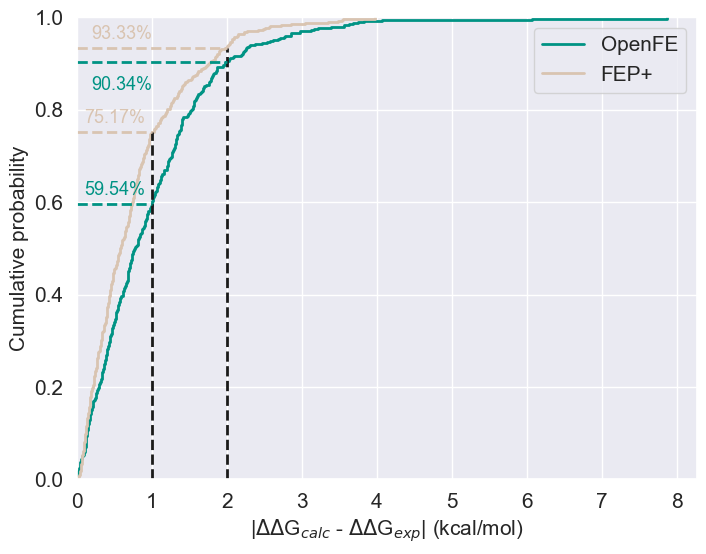

In [120]:
# plot the cdf of the absolute errors
# make the dataframe
fig, ax = plt.subplots(figsize=(8, 6))

openfe_abs_ddg = np.abs(overlap_df_final["OpenFE DDG (kcal/mol)"] - overlap_df_final["exp DDG (kcal/mol)"])
fep_plus_ddg = overlap_df_final["FEP+ Bennett ddG (kcal/mol)"]
fep_plus_abs_ddg = np.abs(fep_plus_ddg - overlap_df_final["exp DDG (kcal/mol)"])
sns.ecdfplot(x=openfe_abs_ddg, label="OpenFE", color="#009384", linewidth=2, ax=ax)
sns.ecdfplot(x=fep_plus_abs_ddg, label="FEP+", color="#d9c4b1", linewidth=2, ax=ax)
# calculate the probability of being below 1 kcal/mol for both
prob_below_1_openfe = np.sum(openfe_abs_ddg < 1) / len(openfe_abs_ddg)
prob_below_1_fep_plus = np.sum(fep_plus_abs_ddg < 1) / len(fep_plus_abs_ddg)
print(f"Probability of OpenFE being below 1 kcal/mol: {prob_below_1_openfe:.2%}")
print(f"Probability of FEP+ being below 1 kcal/mol: {prob_below_1_fep_plus:.2%}")
# add a line at 1 kcal/mol for both
ax.axvline(x=1, ymax=prob_below_1_fep_plus, color='k', linestyle='--', linewidth=2)
ax.plot([0, 1], [prob_below_1_openfe, prob_below_1_openfe], color='#009384', linestyle='--', linewidth=2)
ax.plot([0, 1], [prob_below_1_fep_plus, prob_below_1_fep_plus], color='#d9c4b1', linestyle='--', linewidth=2)
# add a label above the line
ax.text(0.1, prob_below_1_openfe + 0.02, f"{prob_below_1_openfe:.2%}", color='#009384', fontsize=13)
ax.text(0.1, prob_below_1_fep_plus + 0.02, f"{prob_below_1_fep_plus:.2%}", color='#d9c4b1', fontsize=13)
# same again for 2  kcal/mol
prob_below_2_openfe = np.sum(openfe_abs_ddg < 2) / len(openfe_abs_ddg)
prob_below_2_fep_plus = np.sum(fep_plus_abs_ddg < 2) / len(fep_plus_abs_ddg)
print(f"Probability of OpenFE being below 2 kcal/mol: {prob_below_2_openfe:.0%}")
print(f"Probability of FEP+ being below 2 kcal/mol: {prob_below_2_fep_plus:.0%}")
# stop the line at the higher probability curve 

ax.axvline(x=2, ymax=prob_below_2_fep_plus, color='k', linestyle='--', linewidth=2)
ax.plot([0, 2], [prob_below_2_openfe, prob_below_2_openfe], color='#009384', linestyle='--', linewidth=2)
ax.plot([0, 2], [prob_below_2_fep_plus, prob_below_2_fep_plus], color='#d9c4b1', linestyle='--', linewidth=2)
# add a label above the line
ax.text(0.2, prob_below_2_openfe - 0.06, f"{prob_below_2_openfe:.2%}", color='#009384', fontsize=13)
ax.text(0.2, prob_below_2_fep_plus + 0.02, f"{prob_below_2_fep_plus:.2%}", color='#d9c4b1', fontsize=13)

plt.legend(prop={"size": 15})
plt.xlim(left=0.0)
plt.ylabel("Cumulative probability", fontdict={"size": 15})
plt.tick_params(labelsize=15)
plt.xlabel(r"|$\Delta\Delta$G$_{calc}$ - $\Delta\Delta$G$_{exp}$| (kcal/mol)", fontdict={"size": 15})
plt.savefig("edgewise_abs_ddg_eror_ecdf_vs_fep.png", bbox_inches="tight", dpi=300)

Probability of OpenFE - FEP+ being below 1 kcal/mol: 67.36%
Probability of OpenFE - FEP+ being below 2 kcal/mol: 91%
Probability of OpenFE - FEP+ being below 0.5 kcal/mol: 41.84%


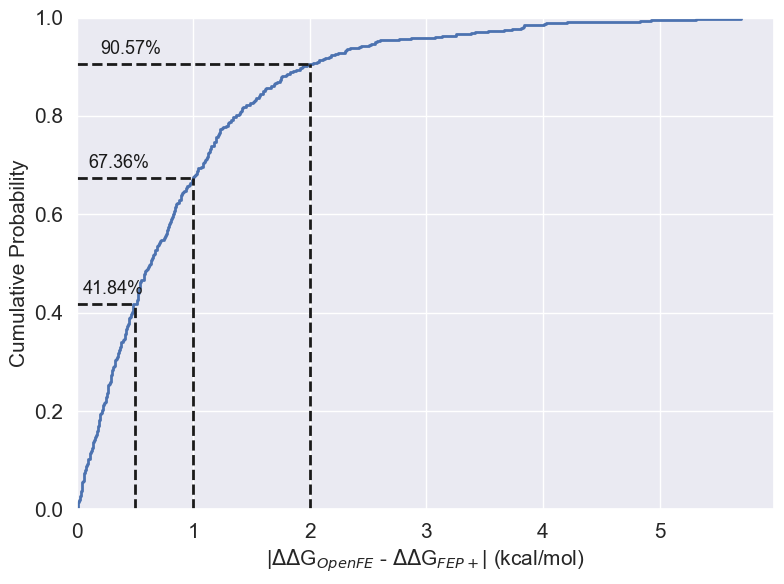

In [121]:
# plot an ecdf of the difference between the openfe and fep+ ddg values
fig, ax = plt.subplots(figsize=(8, 6))
openfe_ddg = overlap_df_final["OpenFE DDG (kcal/mol)"]
fep_plus_ddg = overlap_df_final["FEP+ Bennett ddG (kcal/mol)"]
ddg_diff = np.abs(openfe_ddg - fep_plus_ddg)
sns.ecdfplot(x=ddg_diff, linewidth=2, ax=ax)
# set y axis title
ax.set_ylabel("Cumulative Probability", fontdict={"size": 15})
# set x axis title
ax.set_xlabel(r"|$\Delta\Delta$G$_{OpenFE}$ - $\Delta\Delta$G$_{FEP+}$| (kcal/mol)", fontdict={"size": 15})
# work out the probability of being below 1 kcal/mol
prob_below_1 = np.sum(ddg_diff < 1) / len(ddg_diff)
print(f"Probability of OpenFE - FEP+ being below 1 kcal/mol: {prob_below_1:.2%}")
# add a line at 1 kcal/mol
ax.axvline(x=1, ymax=prob_below_1, color='k', linestyle='--', linewidth=2)
ax.plot([0, 1], [prob_below_1, prob_below_1], color='k', linestyle='--', linewidth=2)
# add a label above the line
ax.text(0.1, prob_below_1 + 0.02, f"{prob_below_1:.2%}", color='k', fontsize=13)
# work out the probability of being below 2 kcal/mol
prob_below_2 = np.sum(ddg_diff < 2) / len(ddg_diff)
print(f"Probability of OpenFE - FEP+ being below 2 kcal/mol: {prob_below_2:.0%}")
# add a line at 2 kcal/mol
ax.axvline(x=2, ymax=prob_below_2, color='k', linestyle='--', linewidth=2)
ax.plot([0, 2], [prob_below_2, prob_below_2], color='k', linestyle='--', linewidth=2)
# add a label above the line
ax.text(0.2, prob_below_2 + 0.02, f"{prob_below_2:.2%}", color='k', fontsize=13)
# workout the probability of being below 0.5 kcal/mol
prob_below_05 = np.sum(ddg_diff < 0.5) / len(ddg_diff)
print(f"Probability of OpenFE - FEP+ being below 0.5 kcal/mol: {prob_below_05:.2%}")
# add a line at 0.5 kcal/mol    
ax.axvline(x=0.5, ymax=prob_below_05, color='k', linestyle='--', linewidth=2)
ax.plot([0, 0.5], [prob_below_05, prob_below_05], color='k', linestyle='--', linewidth=2)
# add a label above the line
ax.text(0.05, prob_below_05 + 0.02, f"{prob_below_05:.2%}", color='k', fontsize=13)
# set the x and y tick font size
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
plt.xlim(left=0.0)
# plt.legend(prop={"size": 15})
plt.tight_layout()
plt.savefig("edgewise_ddg_diff_ecdf.png", bbox_inches="tight", dpi=300)

In [122]:
def calculate_rmse_and_mue_overlap(df):
    """
    Calculate RMSE and MUE for OpenFE and FEP+ using the overlap dataframe or a subset of it.
    """
    results = []
    openfe_values = df["OpenFE DDG (kcal/mol)"].values
    fep_plus_values = df["FEP+ Bennett ddG (kcal/mol)"].values
    exp_values = df["exp DDG (kcal/mol)"].values
    for calculated, label in zip([openfe_values, fep_plus_values], ["OpenFE", "FEP+"]):
        for stat in ["RMSE", "MUE"]:
            s = bootstrap_statistic(y_true=exp_values, y_pred=calculated, statistic=stat)
            results.append({
                "Protocol": label,
                "Stat": stat,
                "MLE": s["mle"],
                "Low": s["low"],
                "High": s["high"]
            })
    return pd.DataFrame(results)
    

overall_stats = calculate_rmse_and_mue_overlap(overlap_df_final)
print(overall_stats)

  Protocol  Stat       MLE       Low      High
0   OpenFE  RMSE  1.320035  1.172532  1.474098
1   OpenFE   MUE  0.986337  0.903988  1.065212
2     FEP+  RMSE  1.017799  0.932883  1.108757
3     FEP+   MUE  0.764467  0.703143  0.825999


In [123]:
from scipy.stats import wilcoxon
stat, p = wilcoxon(openfe_ddg, fep_plus_ddg)
# any significant difference?
if p < 0.05:
    print("There is a significant difference between OpenFE and FEP+ DDG values.")
else:
    print("There is no significant difference between OpenFE and FEP+ DDG values.")
print(f"Wilcoxon signed-rank test statistic: {stat}, p-value: {p}")

There is a significant difference between OpenFE and FEP+ DDG values.
Wilcoxon signed-rank test statistic: 40302.0, p-value: 0.0067040272788853284


In [124]:
# how many edges are charge changes
overlap_df_final[overlap_df_final["alchemical_charge_difference"] != 0.0]

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_2_smallest_overlap,failed,system group,system name,FEP+ Bennett ddG (kcal/mol),FEP+ Bennett std. error (kcal/mol),FEP+ CCC ddG (kcal/mol),FEP+ CCC std. error (kcal/mol),OpenFE DDG (kcal/mol),OpenFE dDDG (kcal/mol)
1,39charg,34,0.0,-1,0.614286,0.012182,0.980239,0.988664,27,0,...,0.206549,NaN,charge_annihilation_set,cdk2,-1.898499,0.098677,-2.01,0.34,-2.734255,0.244470
2,39charg,25,0.0,-1,0.614286,0.045757,0.985675,0.724526,25,2,...,0.198287,NaN,charge_annihilation_set,cdk2,-1.348801,0.092692,-1.54,0.37,-2.866959,0.355077
6,9,4charg,0.0,-1,0.614286,0.072997,0.874647,0.961433,23,3,...,0.170496,NaN,charge_annihilation_set,dlk,-0.415100,0.075213,-0.41,0.21,0.977934,0.091531
7,17charg,18,0.0,1,0.614286,0.123677,0.837373,0.812274,24,4,...,0.190207,NaN,charge_annihilation_set,dlk,-0.183899,0.083189,-0.15,0.25,-0.087894,0.081369
11,21,30charg,0.0,-1,0.614286,0.149241,0.724080,0.732328,37,6,...,0.200005,NaN,charge_annihilation_set,egfr,1.050000,0.100000,0.80,0.35,2.259027,0.181022
12,21,27chargR,0.0,-1,0.614286,0.135585,0.696112,0.832751,37,6,...,0.206002,NaN,charge_annihilation_set,egfr,0.190000,0.090000,0.25,0.34,1.982641,0.168933
15,19charg,20,0.0,-1,0.614286,0.023911,0.976154,0.885372,21,0,...,0.206997,NaN,charge_annihilation_set,ephx2,-3.172100,0.258688,-2.59,0.71,-1.974215,0.538446
16,47charg,33,0.0,-1,0.614286,0.140696,0.911633,0.491555,25,3,...,0.225573,NaN,charge_annihilation_set,ephx2,-0.610399,0.124347,-0.77,0.63,-0.686979,0.314083
21,6,5charg,0.0,-1,0.614286,0.167414,0.745609,0.910471,27,0,...,0.156882,NaN,charge_annihilation_set,irak4_s2,-3.072998,0.094204,-3.32,0.68,-2.099726,0.203072
22,17charg,18,0.0,1,0.614286,0.046374,0.952098,0.901998,32,1,...,0.196707,NaN,charge_annihilation_set,irak4_s2,-2.658703,0.104952,-2.89,0.68,-2.133127,0.166192


Wilcoxon signed-rank test statistic for absolute errors: 237.0, p-value: 0.8392556216567755


/var/folders/9q/nm__l0v13fggc72v94p0hybw0000gq/T/ipykernel_4080/4137505825.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["OpenFE", "FEP+"], fontsize=15)


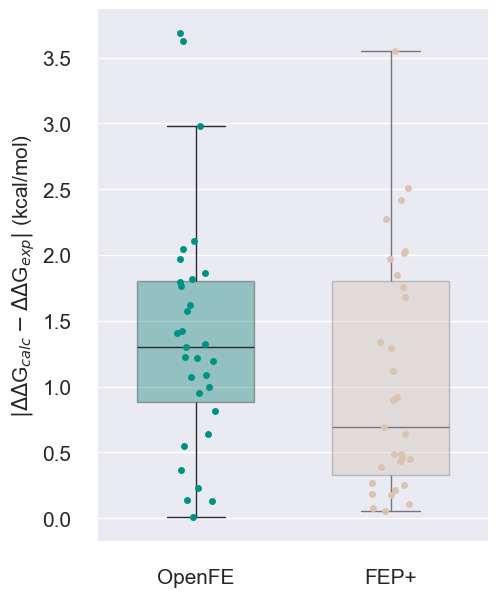

In [118]:
import seaborn as sns
from scipy.stats import wilcoxon
sns.set_style("darkgrid")
# sns.set_theme(style="ticks")
charge_change_data = []
charged_edges = overlap_df_final[overlap_df_final["alchemical_charge_difference"] != 0.0].copy(deep=True).reset_index(drop=True)
complex_data = charged_edges[[f"complex_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
complex_dg = complex_data.mean(axis=1)
solvent_data = charged_edges[[f"solvent_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
solvent_dg = solvent_data.mean(axis=1)
openfe_ddg = complex_dg - solvent_dg
charged_edges["abs_error"] = np.abs(openfe_ddg - charged_edges["exp DDG (kcal/mol)"])
fep_plus_error = np.abs(charged_edges["FEP+ Bennett ddG (kcal/mol)"] - charged_edges["exp DDG (kcal/mol)"])

# wilcoxon test for the predictions
stat, p = wilcoxon(openfe_ddg, charged_edges["FEP+ Bennett ddG (kcal/mol)"])
print(f"Wilcoxon signed-rank test statistic for absolute errors: {stat}, p-value: {p}")
if p < 0.05:
    print("There is a significant difference between OpenFE and FEP+ absolute errors for charge change edges.")
# plot the absolute errors for OpenFE and FEP+ with a boxplot and stripplot
fig, ax = plt.subplots(figsize=(5, 6))
sns.boxplot(y=charged_edges["abs_error"], ax=ax, x=0, color="#009384", boxprops={"alpha": 0.4}, fliersize=0, width=0.6)
sns.boxplot(y=fep_plus_error, ax=ax, x=0.5, color="#d9c4b1", boxprops={"alpha": 0.4}, fliersize=0, width=0.6)
# add the points to the boxplot
sns.stripplot(y=charged_edges["abs_error"], x=0, ax=ax, color="#009384", size=5)
sns.stripplot(y=fep_plus_error, x=0.5, ax=ax, color="#d9c4b1", size=5)
# ax.set_xticks([0, 0.5])
ax.set_xticklabels(["OpenFE", "FEP+"], fontsize=15)
ax.set_ylabel(r"$|\Delta\Delta$G$_{calc} - \Delta\Delta$G$_{exp}|$ (kcal/mol)", fontsize=15)
# ax.set_xlabel("Charge difference", fontsize=15)
ax.tick_params(labelsize=15)
plt.tight_layout()
sns.despine(offset=10)
plt.savefig("charge_change_abs_error_boxplot.png", dpi=300, bbox_inches='tight')



In [125]:
charged_overlap_df = overlap_df_final[overlap_df_final["alchemical_charge_difference"] != 0.0].copy(deep=True).reset_index(drop=True)
charged_stats = calculate_rmse_and_mue_overlap(charged_overlap_df)
print(charged_stats)

  Protocol  Stat       MLE       Low      High
0   OpenFE  RMSE  1.646792  1.285314  2.009675
1   OpenFE   MUE  1.385378  1.104106  1.720490
2     FEP+  RMSE  1.391316  1.038536  1.729448
3     FEP+   MUE  1.063989  0.741113  1.413825


In [126]:
neutral_overlap_df = overlap_df_final[overlap_df_final["alchemical_charge_difference"] == 0.0].copy(deep=True).reset_index(drop=True)
neutral_stats = calculate_rmse_and_mue_overlap(neutral_overlap_df)
print(neutral_stats)

  Protocol  Stat       MLE       Low      High
0   OpenFE  RMSE  1.291552  1.154240  1.445401
1   OpenFE   MUE  0.955718  0.875325  1.043665
2     FEP+  RMSE  0.983294  0.890854  1.070323
3     FEP+   MUE  0.741484  0.682213  0.800748


In [78]:
# sort the edges by the absolute error of the openfe ddg values
overlap_df_final["abs_error"] = np.abs(overlap_df_final["exp DDG (kcal/mol)"] - openfe_ddg)
overlap_df_final = overlap_df_final.sort_values("abs_error", ascending=False).reset_index(drop=True)
overlap_df_final.head(10)

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_2_ligand_rmsd_max,complex_repeat_2_smallest_overlap,failed,system group,system name,FEP+ Bennett ddG (kcal/mol),FEP+ Bennett std. error (kcal/mol),FEP+ CCC ddG (kcal/mol),FEP+ CCC std. error (kcal/mol),abs_error
0,18,6,0.272532,0,1.000000,0.111050,0.727850,1.000000,26,6,...,2.305891,0.100091,NaN,charge_annihilation_set,irak4_s2,3.468498,0.063091,3.38,0.68,7.180839
1,6,14,0.272532,0,1.000000,0.121166,0.718486,1.000000,26,1,...,2.147723,0.082376,NaN,charge_annihilation_set,irak4_s2,-3.828598,0.059175,-3.74,0.57,6.174566
2,47charg,19charg,0.149569,0,1.000000,0.197246,0.721490,0.950349,19,9,...,5.537189,0.001244,NaN,charge_annihilation_set,ephx2,3.702999,0.180054,3.96,0.63,4.160886
3,17charg,18,0.000000,1,0.614286,0.046374,0.952098,0.901998,32,1,...,2.628356,0.196707,NaN,charge_annihilation_set,irak4_s2,-2.658703,0.104952,-2.89,0.68,3.785001
4,29,27,0.246597,0,1.000000,0.077786,0.474972,1.000000,23,7,...,2.951667,0.138580,NaN,charge_annihilation_set,irak4_s3,0.640700,0.135275,0.72,0.39,3.698801
5,4charg,8,0.246597,0,1.000000,0.048722,0.579467,1.000000,20,3,...,4.066833,0.134652,NaN,charge_annihilation_set,dlk,-2.079220,0.075612,-1.96,0.25,3.439028
6,9,18,0.060810,0,1.000000,0.194365,0.041573,0.997216,14,12,...,4.486603,0.055896,NaN,charge_annihilation_set,dlk,-1.387899,0.151989,-1.51,0.25,3.232641
7,34,25,0.670320,0,1.000000,0.057515,0.966424,0.730672,25,2,...,4.468362,0.111000,NaN,charge_annihilation_set,cdk2,0.390140,0.073038,0.46,0.37,2.784255
8,6,5charg,0.000000,-1,0.614286,0.167414,0.745609,0.910471,27,0,...,2.705249,0.156882,NaN,charge_annihilation_set,irak4_s2,-3.072998,0.094204,-3.32,0.68,2.701743
9,18,14,0.951229,0,1.000000,0.012752,0.984458,1.000000,32,0,...,2.363351,0.134893,NaN,charge_annihilation_set,irak4_s2,-0.214110,0.068878,-0.36,0.45,2.606950


In [51]:
all_dg_data

,ligand name,DG (kcal/mol),uncertainty (kcal/mol),Exp DG (kcal/mol),Exp dDG (kcal/mol),partner_id,dataset_name,system group,system name,FEP+ DG (kcal/mol),FEP+ DG std. error (kcal/mol)
0,34,-10.172449,0.117421,-9.880000,0.0,EliLilly,eli_lilly_charge/charge_annihilation_cdk2/resu...,charge_annihilation_set,cdk2,-10.23,0.25
1,25,-9.867576,0.139560,-9.830000,0.0,EliLilly,eli_lilly_charge/charge_annihilation_cdk2/resu...,charge_annihilation_set,cdk2,-9.77,0.26
2,39charg,-7.297475,0.136737,-8.370000,0.0,EliLilly,eli_lilly_charge/charge_annihilation_cdk2/resu...,charge_annihilation_set,cdk2,-8.23,0.25
3,17charg,-10.296180,0.073111,-10.440000,0.0,NaN,charge_annhil_dlk/charge_annhil_dlk/results_data,charge_annihilation_set,dlk,-10.69,0.19
4,8,-10.185925,0.086863,-10.510000,0.0,NaN,charge_annhil_dlk/charge_annhil_dlk/results_data,charge_annihilation_set,dlk,-10.91,0.19
...,...,...,...,...,...,...,...,...,...,...,...
35,24,-7.502059,0.198432,-8.869909,0.0,NaN,NaN,merck,pfkfb3,-9.06,0.07
36,33,-8.514623,0.186763,-8.606922,0.0,NaN,NaN,merck,pfkfb3,-9.51,0.07
37,30_flip_b,-7.261508,0.201435,-9.198191,0.0,NaN,NaN,merck,pfkfb3,-8.98,0.07
38,31,-9.492619,0.233194,-9.282473,0.0,NaN,NaN,merck,pfkfb3,-9.45,0.07


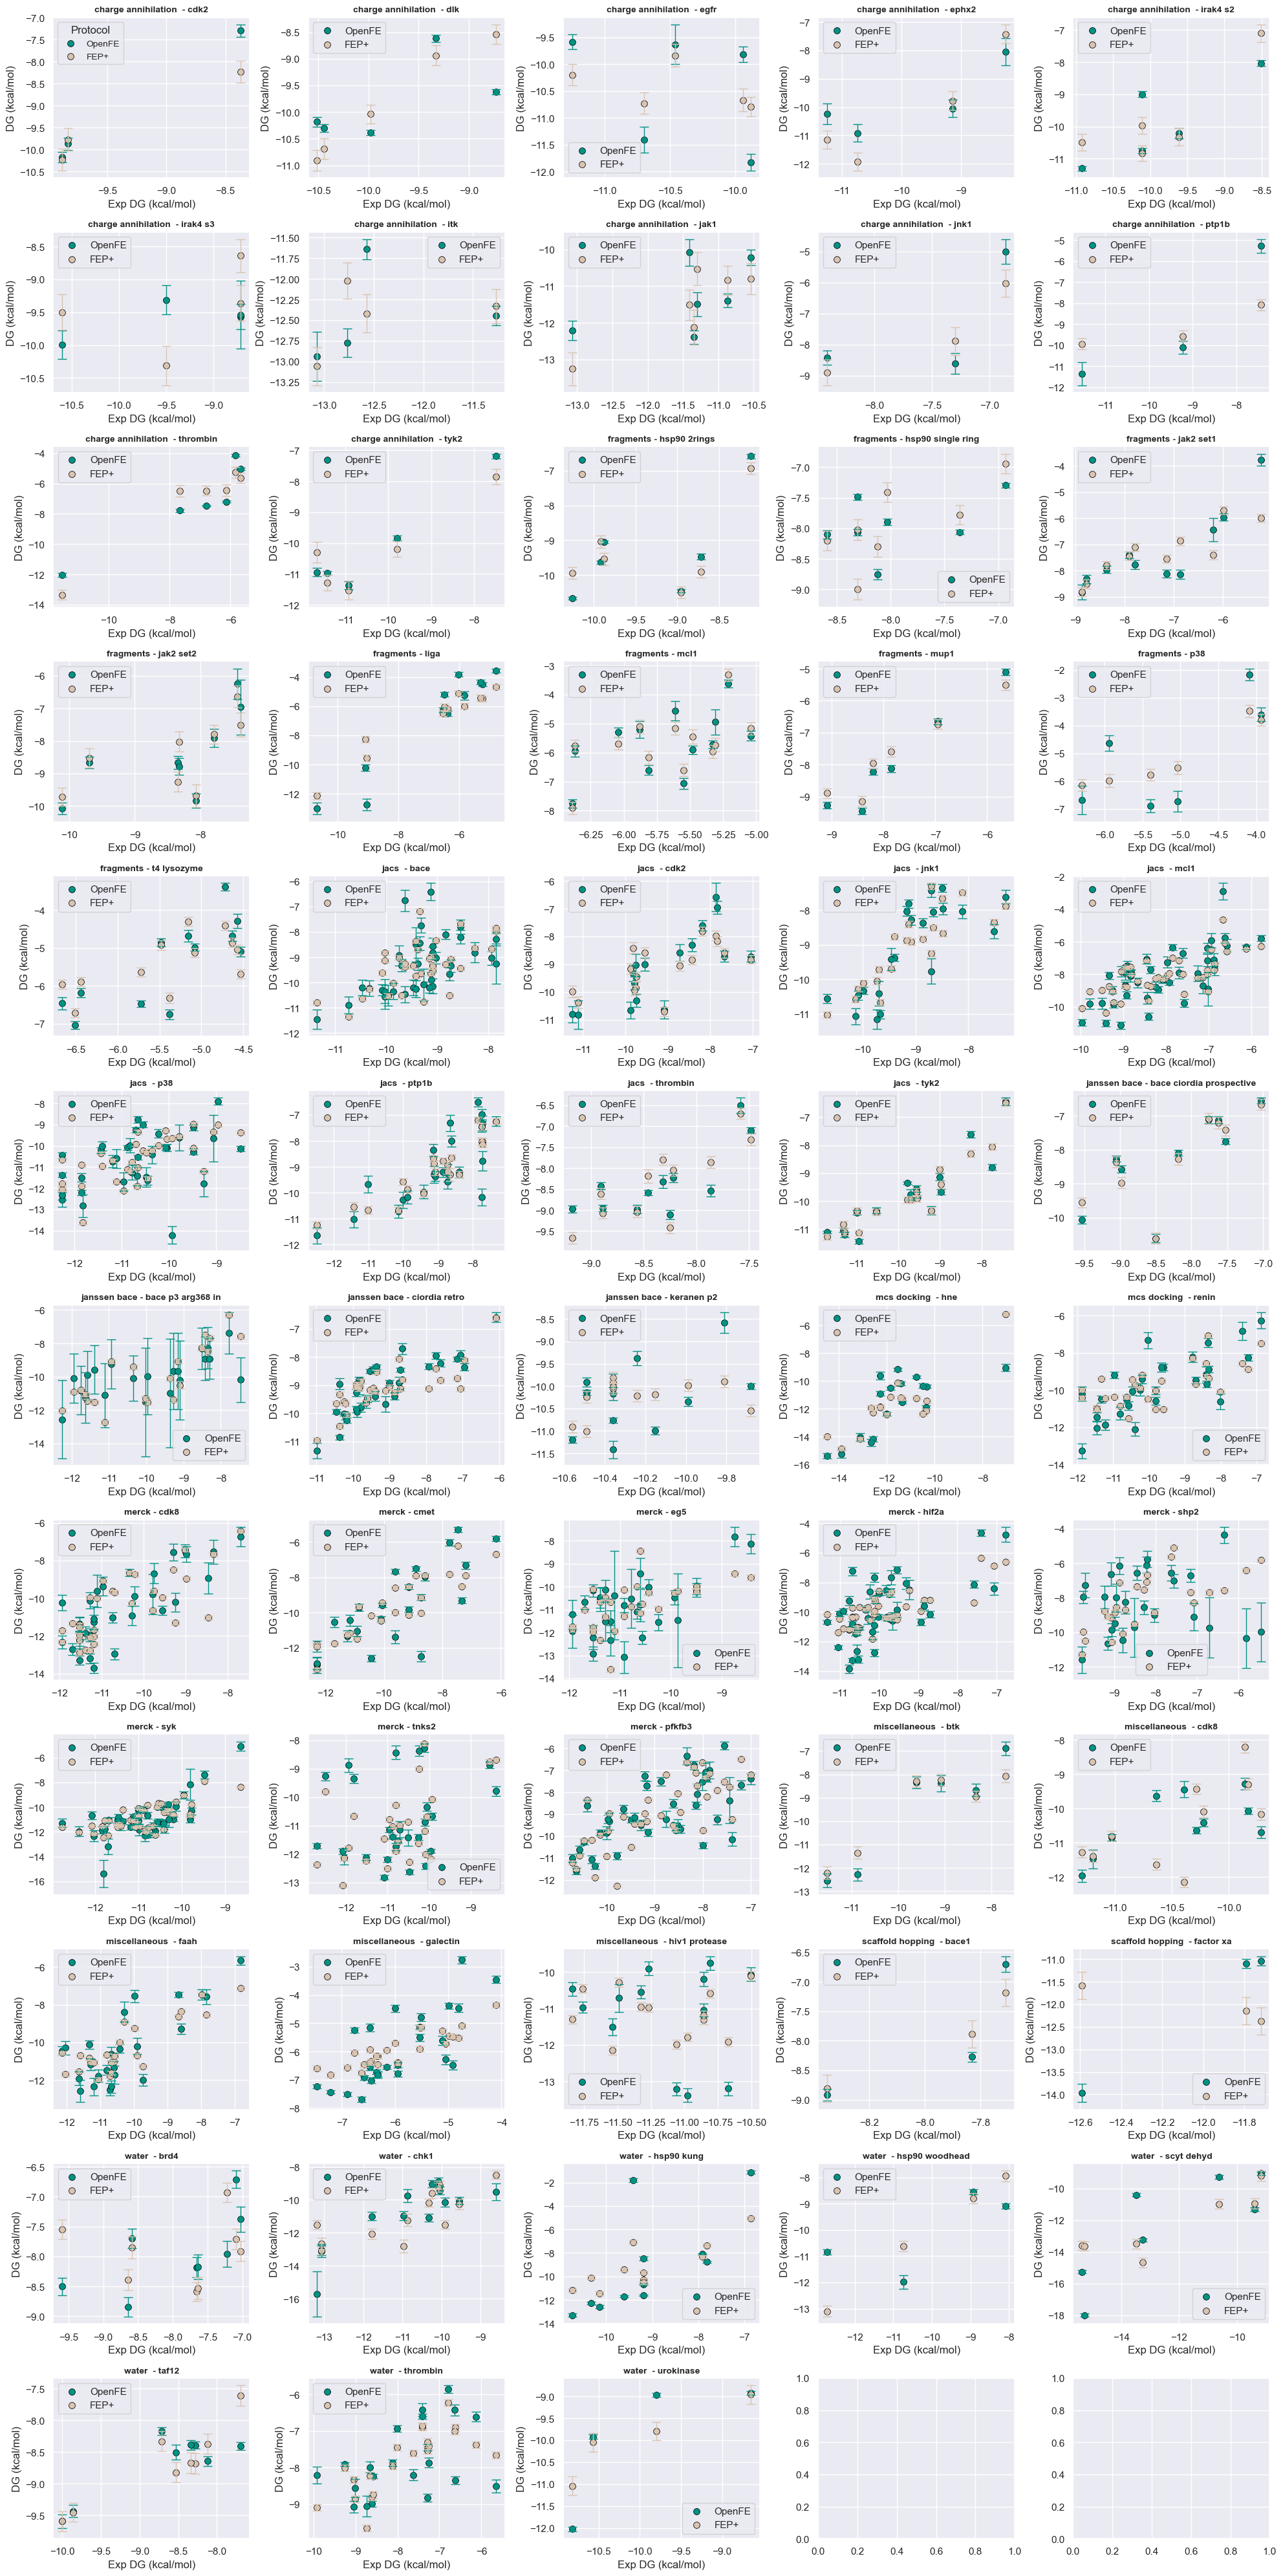

In [52]:
# create a 12 by 5 grid of subplots for the openfe and FEP+ dg values compared to the experimental values include error bars RMSE, MUE R2 and kendall tau should be in the legend
fig, axs = plt.subplots(12, 5, figsize=(20, 40))
# Flatten the axes array for easier iteration
axs = axs.flatten()
i = 0
# Loop through each system and plot the data
system_groups = all_dg_data["system group"].unique()
for system in system_groups:
    system_df = all_dg_data[all_dg_data["system group"] == system].copy(deep=True).reset_index(drop=True)
    # get the unique target names
    target_names = system_df["system name"].unique()
    for target in target_names:
        # get the edges for this target
        target_df = system_df[system_df["system name"] == target].copy(deep=True).reset_index(drop=True)
        # plot the data
        sns.scatterplot(x=target_df["Exp DG (kcal/mol)"], y=target_df["DG (kcal/mol)"], ax=axs[i], color="#009384", label="OpenFE", s=50, edgecolor='black')
        sns.scatterplot(x=target_df["Exp DG (kcal/mol)"], y=target_df["FEP+ DG (kcal/mol)"], ax=axs[i], color="#d9c4b1", label="FEP+", s=50, edgecolor='black')
        # add the error bars for 
        axs[i].errorbar(target_df["Exp DG (kcal/mol)"], target_df["DG (kcal/mol)"], 
                        yerr=target_df["uncertainty (kcal/mol)"], fmt='none', color="#009384", capsize=5, elinewidth=1) 
        axs[i].errorbar(target_df["Exp DG (kcal/mol)"], target_df["FEP+ DG (kcal/mol)"], 
                        yerr=target_df["FEP+ DG std. error (kcal/mol)"], fmt='none', color="#d9c4b1", capsize=5, elinewidth=1)
        # calculate the RMSE and MUE for OpenFE and FEP+
        openfe_rmse, openfe_mue = calculate_rmse_mue(target_df["Exp DG (kcal/mol)"].values, target_df["DG (kcal/mol)"].values)
        fep_plus_rmse, fep_plus_mue = calculate_rmse_mue(target_df["Exp DG (kcal/mol)"].values, target_df["FEP+ DG (kcal/mol)"].values)
        # calculate the R2 and Kendall tau
        axs[i].set_title(f"{system.replace('_', ' ').replace("set","")} - {target.replace('_', ' ')}", fontsize=10, fontweight='bold')

        i += 1
axs[0].legend(title="Protocol", fontsize=10, loc='upper left')
plt.tight_layout() 

In [54]:
from scipy.stats import kendalltau
def calculate_kendall_tau(df, system_group, system_name):
    target_df = df[(df["system group"] == system_group) & (df["system name"] == system_name)].copy(deep=True).reset_index(drop=True)
    openfe_tau, _ = kendalltau(target_df["Exp DG (kcal/mol)"], target_df["DG (kcal/mol)"])
    fep_plus_tau, _ = kendalltau(target_df["Exp DG (kcal/mol)"], target_df["FEP+ DG (kcal/mol)"])
    return openfe_tau, fep_plus_tau


In [57]:
calculate_kendall_tau(all_dg_data, "fragments", "liga")

(0.7090909090909091, 0.7818181818181819)

In [58]:
# workout the errors for the overlapping dataset!
# get the openfe error
exp_ddg = overlap_df_final["exp DDG (kcal/mol)"]
# exp_error = df["exp dDDG (kcal/mol)"]
# calculate the DDG using the std between repeats as the error
complex_data = overlap_df_final[[f"complex_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
complex_dg = complex_data.mean(axis=1)
complex_error = complex_data.std(axis=1)
solvent_data = overlap_df_final[[f"solvent_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
solvent_dg = solvent_data.mean(axis=1)
solvent_error = solvent_data.std(axis=1)
ddg = complex_dg - solvent_dg
openfe_error = abs(ddg - exp_ddg)
fep_error = abs(exp_ddg - overlap_df_final["FEP+ Bennett ddG (kcal/mol)"])
overlap_high_error = overlap_df_final[(fep_error > 1.5) & (openfe_error > 1.5)].copy(deep=True).reset_index(drop=True)
# overlap_high_error
overlap_openfe_better = overlap_df_final[openfe_error + 1.0 < fep_error].copy(deep=True).reset_index(drop=True)
overlap_fep_plus_better = overlap_df_final[fep_error + 1.0 < openfe_error]


In [59]:
overlap_openfe_better

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_2_com_drift_max,complex_repeat_2_ligand_rmsd_max,complex_repeat_2_smallest_overlap,failed,system group,system name,FEP+ Bennett ddG (kcal/mol),FEP+ Bennett std. error (kcal/mol),FEP+ CCC ddG (kcal/mol),FEP+ CCC std. error (kcal/mol)
0,19charg,20,0.000000,-1,0.614286,0.023911,0.976154,0.885372,21,0,...,2.310055,3.244344,0.206997,NaN,charge_annihilation_set,ephx2,-3.172100,0.258688,-2.59,0.71
1,6,14,0.272532,0,1.000000,0.121166,0.718486,1.000000,26,1,...,1.824536,2.147723,0.082376,NaN,charge_annihilation_set,irak4_s2,-3.828598,0.059175,-3.74,0.57
2,17charg,5charg,0.074274,0,1.000000,0.169549,0.549579,0.997435,26,7,...,2.102619,2.409687,0.024435,NaN,charge_annihilation_set,irak4_s2,-2.846001,0.115958,-2.83,0.54
3,17charg,14,0.000000,1,0.614286,0.043588,0.973313,0.797078,32,1,...,1.992569,2.305557,0.209882,NaN,charge_annihilation_set,irak4_s2,-3.547302,0.079206,-3.25,0.68
4,19charg,28charg,0.904837,0,1.000000,0.009149,1.000000,0.925315,29,0,...,2.012265,2.331582,0.034305,NaN,charge_annihilation_set,irak4_s3,-0.670799,0.145930,-0.81,0.61
5,18charg,16charg,0.670320,0,1.000000,0.141745,0.828898,0.720819,19,4,...,41.929405,42.173965,0.016841,NaN,charge_annihilation_set,jak1,-1.248400,0.227266,-1.57,0.94
6,11,jmb2009-4,0.122456,0,1.000000,0.307974,0.530133,0.330947,20,8,...,74.396599,74.477402,0.035421,NaN,charge_annihilation_set,thrombin,-8.176704,0.134167,-8.09,0.63
7,1,jmb2009-4,0.000000,-1,0.714286,0.309431,0.826116,0.213292,26,0,...,77.451523,78.000198,0.138666,NaN,charge_annihilation_set,thrombin,-6.757004,0.137486,-6.88,0.63
8,6,7,0.522046,0,1.000000,0.229904,0.631117,0.518321,16,1,...,2.174964,2.272170,0.140105,NaN,fragments,jak2_set1,-1.267401,0.090119,-1.42,0.32
9,21,18,0.522046,0,1.000000,0.250361,0.688868,0.630607,20,5,...,2.492551,3.057518,0.027755,NaN,fragments,jak2_set2,1.417603,0.235796,1.23,0.51


In [60]:
# for the openfe better edges print the exp ddg, openfe ddg, fep+ ddg and if openfe and FEP+ have the same sign
openfe_sign_correct = 0
fep_plus_sign_correct = 0
for _, row in overlap_openfe_better.iterrows():
    exp_ddg = row["exp DDG (kcal/mol)"]
    complex_data = row[[f"complex_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
    complex_dg = complex_data.mean()
    solvent_data = row[[f"solvent_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
    solvent_dg = solvent_data.mean()
    openfe_ddg = complex_dg - solvent_dg
    fep_plus_ddg = row["FEP+ Bennett ddG (kcal/mol)"]
    # get the % of correct sign for openfe and fep+
    if np.sign(openfe_ddg) == np.sign(exp_ddg):
        openfe_sign_correct += 1
    if np.sign(fep_plus_ddg) == np.sign(exp_ddg):
        fep_plus_sign_correct += 1
print(f"OpenFE sign correct: {openfe_sign_correct} / {len(overlap_openfe_better)}")
print(f"FEP+ sign correct: {fep_plus_sign_correct} / {len(overlap_openfe_better)}")

OpenFE sign correct: 26 / 29
FEP+ sign correct: 11 / 29


In [61]:
overlap_fep_plus_better

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_2_com_drift_max,complex_repeat_2_ligand_rmsd_max,complex_repeat_2_smallest_overlap,failed,system group,system name,FEP+ Bennett ddG (kcal/mol),FEP+ Bennett std. error (kcal/mol),FEP+ CCC ddG (kcal/mol),FEP+ CCC std. error (kcal/mol)
2,39charg,25,0.000000,-1,0.614286,0.045757,0.985675,0.724526,25,2,...,31.980310,32.360592,0.198287,NaN,charge_annihilation_set,cdk2,-1.348801,0.092692,-1.54,0.37
6,9,4charg,0.000000,-1,0.614286,0.072997,0.874647,0.961433,23,3,...,5.095422,5.597771,0.170496,NaN,charge_annihilation_set,dlk,-0.415100,0.075213,-0.41,0.21
10,28charg,29charg,0.272532,0,1.000000,0.199291,0.643186,0.718440,37,8,...,20.654922,23.500959,0.008467,NaN,charge_annihilation_set,egfr,0.630000,0.170000,0.91,0.41
11,21,30charg,0.000000,-1,0.614286,0.149241,0.724080,0.732328,37,6,...,26.147697,28.054455,0.200005,NaN,charge_annihilation_set,egfr,1.050000,0.100000,0.80,0.35
12,21,27chargR,0.000000,-1,0.614286,0.135585,0.696112,0.832751,37,6,...,31.912266,33.085949,0.206002,NaN,charge_annihilation_set,egfr,0.190000,0.090000,0.25,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,8d,5d,0.951229,0,1.000000,0.008593,0.989725,1.000000,26,0,...,2.059604,3.088306,0.128821,NaN,water_set,scyt_dehyd,-2.809399,0.056224,-3.20,0.73
414,4d,7d,0.951229,0,1.000000,0.008734,0.982031,1.000000,28,0,...,1.489752,2.184007,0.111349,NaN,water_set,scyt_dehyd,-0.208810,0.063382,-0.04,0.68
416,2d,5d,0.951229,0,1.000000,0.008595,0.965459,1.000000,26,0,...,1.581741,2.377913,0.111374,NaN,water_set,scyt_dehyd,-1.379640,0.031214,-1.07,0.73
425,"10302 (1GJ7, no water pose)",11417 (no water pose),0.951229,0,1.000000,0.024929,1.000000,0.835583,26,0,...,1.275678,1.979147,0.232292,NaN,water_set,urokinase,1.069530,0.044299,0.99,0.12


In [62]:
openfe_sign_correct = 0
fep_plus_sign_correct = 0
for _, row in overlap_fep_plus_better.iterrows():
    exp_ddg = row["exp DDG (kcal/mol)"]
    complex_data = row[[f"complex_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
    complex_dg = complex_data.mean()
    solvent_data = row[[f"solvent_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
    solvent_dg = solvent_data.mean()
    openfe_ddg = complex_dg - solvent_dg
    fep_plus_ddg = row["FEP+ Bennett ddG (kcal/mol)"]
    # get the % of correct sign for openfe and fep+
    if np.sign(openfe_ddg) == np.sign(exp_ddg):
        openfe_sign_correct += 1
    if np.sign(fep_plus_ddg) == np.sign(exp_ddg):
        fep_plus_sign_correct += 1
print(f"OpenFE sign correct: {openfe_sign_correct} / {len(overlap_fep_plus_better)}")
print(f"FEP+ sign correct: {fep_plus_sign_correct} / {len(overlap_fep_plus_better)}")

OpenFE sign correct: 45 / 70
FEP+ sign correct: 56 / 70


In [ ]:
overlap_high_error.to_csv("overlap_high_error_edges.csv")
overlap_openfe_better.to_csv("overlap_openfe_better.csv")
overlap_fep_plus_better.to_csv("overlap_fep_plus_better.csv")



<Axes: >

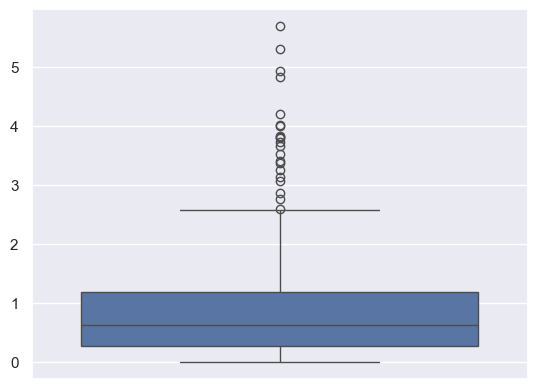

In [63]:
# box plot of differences find the list of outliers
diff_prediction = abs(ddg - overlap_df_final["FEP+ Bennett ddG (kcal/mol)"])
sns.boxplot(diff_prediction)


In [64]:
# find systems with a lot of large differences
complex_data = overlap_df_final[[f"complex_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
complex_dg = complex_data.mean(axis=1)
solvent_data = overlap_df_final[[f"solvent_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
solvent_dg = solvent_data.mean(axis=1)
ddg = complex_dg - solvent_dg
overlap_df_final["ABS diff predition"] = abs(ddg - overlap_df_final["FEP+ Bennett ddG (kcal/mol)"])
sorted_by_abs_diff = overlap_df_final.sort_values("ABS diff predition").copy(deep=True).reset_index(drop=True)

In [65]:
sorted_by_abs_diff[sorted_by_abs_diff["ABS diff predition"] < 0.5]

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_2_ligand_rmsd_max,complex_repeat_2_smallest_overlap,failed,system group,system name,FEP+ Bennett ddG (kcal/mol),FEP+ Bennett std. error (kcal/mol),FEP+ CCC ddG (kcal/mol),FEP+ CCC std. error (kcal/mol),ABS diff predition
0,6,4,0.891366,0,1.0,0.107086,0.560987,0.864729,12,1,...,3.146704,0.195689,NaN,fragments,liga,-0.789531,0.111181,-0.61,0.43,0.001174
1,17,jmc_22,0.704688,0,1.0,0.130297,0.795996,0.952210,19,0,...,43.446098,0.074772,NaN,charge_annihilation_set,jak1,-0.999200,0.126537,-1.28,0.94,0.007235
2,15,14,0.904837,0,1.0,0.066559,0.944917,0.787353,25,1,...,1.679839,0.033208,NaN,fragments,hsp90_2rings,-0.380260,0.068676,-0.38,0.07,0.007570
3,18638-1,18634-1,0.670320,0,1.0,0.198600,0.809465,0.494092,26,4,...,6.054121,0.121980,NaN,jacs_set,jnk1,0.170000,0.060278,0.16,0.06,0.008794
4,ortho methyl ethyl benzene,o-xylene,0.904837,0,1.0,0.108985,0.843676,0.832991,8,1,...,4.501090,0.109975,NaN,fragments,t4_lysozyme,0.661330,0.024798,0.65,0.11,0.009263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,1a,1b,0.818731,0,1.0,0.084010,0.593000,0.891675,17,0,...,48.329441,0.121051,NaN,merck,tnks2,-1.346351,0.028891,-1.33,0.03,0.480546
178,3b,5d,0.951229,0,1.0,0.131395,0.958959,0.563948,22,0,...,48.040039,0.135861,NaN,merck,tnks2,1.235100,0.048164,1.22,0.10,0.480876
179,30,31,0.778801,0,1.0,0.057216,0.992881,0.630754,27,1,...,19.107914,0.150669,NaN,jacs_set,cdk2,-0.162200,0.103579,-0.18,0.54,0.481605
180,ejm_42,ejm_54,0.860708,0,1.0,0.090167,0.786514,0.602059,22,0,...,3.825986,0.180321,NaN,jacs_set,tyk2,-0.437901,0.053110,-0.43,0.14,0.485575


In [66]:
system_counts = {}
for _, row in sorted_by_abs_diff[sorted_by_abs_diff["ABS diff predition"] > 0.5].iterrows():
    name = f"{row['system group']}/{row['system name']}"
    if name not in system_counts:
        system_counts[name] = 1
    else:
        system_counts[name] += 1
system_counts

{'miscellaneous_set/btk': 2,
 'miscellaneous_set/cdk8': 5,
 'charge_annihilation_set/ephx2': 3,
 'charge_annihilation_set/irak4_s3': 4,
 'merck/tnks2': 9,
 'jacs_set/tyk2': 3,
 'charge_annihilation_set/irak4_s2': 6,
 'jacs_set/p38': 21,
 'merck/eg5': 9,
 'fragments/mcl1': 3,
 'fragments/t4_lysozyme': 6,
 'charge_annihilation_set/thrombin': 6,
 'mcs_docking_set/hne': 7,
 'mcs_docking_set/renin': 4,
 'charge_annihilation_set/tyk2': 2,
 'merck/syk': 12,
 'jacs_set/jnk1': 3,
 'merck/shp2': 4,
 'merck/cdk8': 6,
 'janssen_bace/bace_ciordia_prospective': 1,
 'fragments/hsp90_single_ring': 2,
 'merck/hif2a': 5,
 'fragments/liga': 4,
 'charge_annihilation_set/dlk': 3,
 'charge_annihilation_set/itk': 4,
 'miscellaneous_set/hiv1_protease': 4,
 'jacs_set/ptp1b': 14,
 'merck/pfkfb3': 3,
 'janssen_bace/bace_p3_arg368_in': 13,
 'merck/cmet': 11,
 'jacs_set/bace': 4,
 'charge_annihilation_set/jak1': 4,
 'fragments/jak2_set1': 4,
 'water_set/urokinase': 3,
 'fragments/mup1': 2,
 'jacs_set/mcl1': 2,
 'j

In [67]:
# sort the systems by the number of edges with a large difference
sorted_systems = sorted(system_counts.items(), key=lambda x: x[1], reverse=True)
for system, count in sorted_systems:
    print(f"{system}: {count} edges with a large difference")

jacs_set/p38: 21 edges with a large difference
jacs_set/ptp1b: 14 edges with a large difference
janssen_bace/bace_p3_arg368_in: 13 edges with a large difference
merck/syk: 12 edges with a large difference
merck/cmet: 11 edges with a large difference
merck/tnks2: 9 edges with a large difference
merck/eg5: 9 edges with a large difference
mcs_docking_set/hne: 7 edges with a large difference
water_set/hsp90_kung: 7 edges with a large difference
charge_annihilation_set/irak4_s2: 6 edges with a large difference
fragments/t4_lysozyme: 6 edges with a large difference
charge_annihilation_set/thrombin: 6 edges with a large difference
merck/cdk8: 6 edges with a large difference
miscellaneous_set/cdk8: 5 edges with a large difference
merck/hif2a: 5 edges with a large difference
fragments/p38: 5 edges with a large difference
water_set/scyt_dehyd: 5 edges with a large difference
charge_annihilation_set/irak4_s3: 4 edges with a large difference
mcs_docking_set/renin: 4 edges with a large difference
m

In [127]:
# load all the ligands
import pathlib
from rdkit import Chem
all_ligands = {}
name_conversions = {
    "41 flip": "41-flip",
    "40 flip": "40-flip",
    "38 flip": "38-flip",
    "30 flip": "30-flip",
    "43 flip": "43-flip",
    "47 flip": "47-flip",
    "48 flip": "48-flip",
    "46 flip": "46-flip",
    "36 out": "36o",
    "37 out": "37o",
    "38 out": "38o",
    "39 out": "39o",
    "28 out": "28o",
    "CHEMBL3402756_2.7 redocked": "CHEMBL3402756_2.7_redocked",
    "CHEMBL3402757_6.5 redocked" : "CHEMBL3402757_6.5_redocked",
    "CHEMBL3402758_10 redocked": "CHEMBL3402758_10_redocked",
    "CHEMBL3402760_1 redocked":"CHEMBL3402760_1_redocked",
    "CHEMBL3402762_1 redocked": "CHEMBL3402762_1_redocked",
    "CHEMBL3402759_5.7 redocked": "CHEMBL3402759_5.7_redocked",
    "CHEMBL3402761_1 redocked": "CHEMBL3402761_1_redocked",
    "Example 22":"Example-22",
    "Example 23": "Example-23",
    "Example 14": "Example-14",
    "Example 9": "Example-9",
    "SHP099-1 Example 7": "SHP099-1-Example-7",
    "Example 28": "Example-28",
    "Example 24": "Example-24",
    "Example 26": "Example-26",
    "Example 6": "Example-6",
    "Example 1": "Example-1",
    "Example 30": "Example-30",
    "Example 8": "Example-8",
    "Example 29": "Example-29",
    "Example 2": "Example-2",
    "Example 25": "Example-25",
    "Example 4": "Example-4",
    "Example 3": "Example-3",
    "Example 27": "Example-27",
    "Example 5": "Example-5",
    "9 flip": "9-flip",
}
key_to_ligand = {}
base_data_folder = pathlib.Path("/Users/joshua/Documents/Software/IndustryBenchmarks2024/industry_benchmarks/input_structures/prepared_structures")
for folder in base_data_folder.glob("*"):
    if folder.is_dir() and folder != "template":
        for target_ligs in folder.glob("*/ligands.sdf"):
            # load the ligands
            supplier = Chem.SDMolSupplier(target_ligs, removeHs=False)
            for lig in supplier:
                name = lig.GetProp("_Name")
                if name in name_conversions:
                    name = name_conversions[name]
                all_ligands[(name, target_ligs.parent.name, folder.name)] = Chem.GetFormalCharge(lig)
                key_to_ligand[(name, target_ligs.parent.name, folder.name)] = lig

In [128]:
from gufe import SmallMoleculeComponent
import kartograf
from kartograf.filters import (
    filter_ringbreak_changes,
    filter_ringsize_changes,
    filter_whole_rings_only,
)
from rdkit.Chem import Draw
grid_x, grid_y = 2, 1
from gufe.visualization.mapping_visualization import draw_mapping
def get_karto_mapping(liga, ligb, target, system):
    mapping_filters = [
            filter_ringbreak_changes,  # default
            filter_ringsize_changes,  # default
            filter_whole_rings_only,  # default
        ]
    mapper = kartograf.KartografAtomMapper(
        # atom_max_distance=10,
        atom_map_hydrogens=True,
        additional_mapping_filter_functions=mapping_filters,
        # map_hydrogens_on_hydrogens_only=True
    )
    ligand_a = SmallMoleculeComponent(key_to_ligand[(liga, target, system)])
    ligand_b = SmallMoleculeComponent(key_to_ligand[(ligb, target, system)])
    mapping =  next(mapper.suggest_mappings(ligand_a, ligand_b))
    return mapping

def draw_mapping_karto(liga, ligb, target, system):
    d2d = Draw.rdMolDraw2D.MolDraw2DSVG(grid_x * 300, grid_y * 300, 300, 300)
    mapping = get_karto_mapping(liga, ligb, target, system)
    return draw_mapping(mapping._compA_to_compB, mapping.componentA.to_rdkit(), mapping.componentB.to_rdkit(), d2d)

In [129]:
from itertools import combinations
import networkx as nx
def is_scaffold_change(liga, ligb, target, system):
    """
    Check if the mapping between two ligands is a scaffold change.
    A scaffold change is defined here as a change where the dummy atoms are connected to the core via two bonds, which is an undefined change OpenFE.
    """
    mapping = get_karto_mapping(liga, ligb, target, system)
    # check if the mapping has any undefined changes, these are changes where the dummy atoms are connected to the core via two bonds
    for atom_map, end_ligand in zip([mapping.componentA_to_componentB, mapping.componentB_to_componentA], [mapping.componentA, mapping.componentB]):
        # track dummy atoms which are connected to core atoms
        dummy_core_connections = []
        # build a graph of only the dummy atoms so we can check for paths between them anchor atoms
        graph = nx.Graph()
        rd_mol = end_ligand.to_rdkit()
        for atom in rd_mol.GetAtoms():
            atom_idx = atom.GetIdx()
            if atom_idx not in atom_map:
                graph.add_node(atom_idx)
                # add edges to the graph for the dummy atoms
                for neighbor in atom.GetNeighbors():
                    neighbor_idx = neighbor.GetIdx()
                    if neighbor_idx not in atom_map:
                        graph.add_edge(atom_idx, neighbor_idx)
                    else:
                        # if the neighbor is in the mapping, then it is a core atom
                        dummy_core_connections.append((atom_idx, neighbor_idx))
        if len(dummy_core_connections) > 1:
            # if there is more than one dummy core connection check for paths between the dummy atoms which are connected to core atoms
            for (dummy_atom_a, _), (dummy_atom_b, _) in combinations(dummy_core_connections, 2):
                if nx.has_path(graph, dummy_atom_a, dummy_atom_b):
                    # if there is a path between the two dummy atoms then it is a scaffold change
                    return True
    return False
                




In [24]:
# test all edges and see if they are scaffold changes
scaffold_changes = []
for _, row in all_openfe_edges.iterrows():
    liga = row["ligand_A"]
    ligb = row["ligand_B"]
    target = row["system name"]
    system = row["system group"]
    if is_scaffold_change(liga, ligb, target, system):
        scaffold_changes.append((liga, ligb, target, system))

no mapping could be found, after applying filters!


In [130]:
scaffold_changes

[('29charg', '30charg', 'egfr', 'charge_annihilation_set'),
 ('27chargR', '28charg', 'egfr', 'charge_annihilation_set'),
 ('28charg', '30charg', 'egfr', 'charge_annihilation_set'),
 ('21', '30charg', 'egfr', 'charge_annihilation_set'),
 ('21', '27chargR', 'egfr', 'charge_annihilation_set'),
 ('9', '11', 'liga', 'fragments'),
 ('11', '10', 'liga', 'fragments'),
 ('5_1WBW', '3', 'p38', 'fragments'),
 ('26', '27', 'mcl1', 'jacs_set'),
 ('33', '48-flip', 'mcl1', 'jacs_set'),
 ('27', '48-flip', 'mcl1', 'jacs_set'),
 ('27', '46-flip', 'mcl1', 'jacs_set'),
 ('27', '47-flip', 'mcl1', 'jacs_set'),
 ('33', '45', 'mcl1', 'jacs_set'),
 ('27', '43-flip', 'mcl1', 'jacs_set'),
 ('28', '46-flip', 'mcl1', 'jacs_set'),
 ('27', '45', 'mcl1', 'jacs_set'),
 ('27', '42', 'mcl1', 'jacs_set'),
 ('6', '18', 'hne', 'mcs_docking_set'),
 ('6', '14', 'hne', 'mcs_docking_set'),
 ('b1i5o', 'b1i4e', 'renin', 'mcs_docking_set'),
 ('b1i2n', 'b1i5o', 'renin', 'mcs_docking_set'),
 ('19', '18-flipped', 'cdk8', 'merck'),
 

In [57]:
cmet = all_openfe_edges[(all_openfe_edges["system group"] == "merck") & (all_openfe_edges["system name"] == "cmet")].copy(deep=True).reset_index(drop=True)
# calculate the abs error in the ddg values
complex_data = cmet[[f"complex_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
complex_dg = complex_data.mean(axis=1)
complex_error = complex_data.std(axis=1)
solvent_data = cmet[[f"solvent_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
solvent_dg = solvent_data.mean(axis=1)
solvent_error = solvent_data.std(axis=1)
ddg = complex_dg - solvent_dg
cmet["abs_error"] = np.abs(ddg - cmet["exp DDG (kcal/mol)"])
cmet = cmet.sort_values("abs_error", ascending=False).copy(deep=True).reset_index(drop=True)
# print the top 10 edges with the largest absolute error
print(cmet.head(10)[["ligand_A", "ligand_B", "exp DDG (kcal/mol)", "abs_error", "alchemical_charge_difference"]])
#

                    ligand_A                  ligand_B  exp DDG (kcal/mol)  \
0          CHEMBL3402741_400          CHEMBL3402764_90           -0.883783   
1           CHEMBL3402742_23          CHEMBL3402764_90            0.808336   
2          CHEMBL3402744_300        CHEMBL3402755_4200            1.563601   
3          CHEMBL3402744_300  CHEMBL3402761_1_redocked           -3.379405   
4           CHEMBL3402763_90          CHEMBL3402764_90            0.000000   
5           CHEMBL3402742_23          CHEMBL3402743_42            0.356780   
6         CHEMBL3402751_2100         CHEMBL3402750_400           -0.982475   
7  CHEMBL3402758_10_redocked          CHEMBL3402764_90            1.301822   
8         CHEMBL3402755_4200  CHEMBL3402761_1_redocked           -4.943007   
9         CHEMBL3402748_5300        CHEMBL3402751_2100           -0.548505   

   abs_error  alchemical_charge_difference  
0   6.072897                             0  
1   4.173762                             0  
2   3.

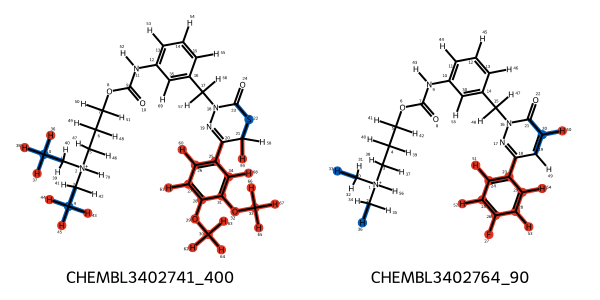

In [64]:
img = draw_mapping_karto("CHEMBL3402741_400", "CHEMBL3402764_90", "cmet", "merck")
from IPython.display import SVG
SVG(img)  # Display the SVG image in Jupyter Notebook
# # write to svf file
# with open("cmet_mapping.svg", "w") as f:
#     f.write(img)

In [65]:
# get a dataframe of the scaffold changes and calculate the RMSE error for the edge wise predictions and compare with the other predictions
import numpy as np
from cinnabar.stats import bootstrap_statistic
scaffold_change_data, no_scaffold_change_data = [], []
for _, row in all_openfe_edges.iterrows():
    liga = row["ligand_A"]
    ligb = row["ligand_B"]
    target = row["system name"]
    system = row["system group"]
    if (liga, ligb, target, system) in scaffold_changes:
        scaffold_change_data.append(row.to_dict())
    else:
        no_scaffold_change_data.append(row.to_dict())
# convert to dataframes
scaffold_change_df = pd.DataFrame(scaffold_change_data)
no_scaffold_change_df = pd.DataFrame(no_scaffold_change_data)
# calculate the RMSE for the edge wise predictions
def calculate_edge_rmse(df):
    complex_data = df[[f"complex_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
    complex_dg = complex_data.mean(axis=1)
    solvent_data = df[[f"solvent_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
    solvent_dg = solvent_data.mean(axis=1)
    ddg = complex_dg - solvent_dg
    exp_ddg = df["exp DDG (kcal/mol)"]
    stats = bootstrap_statistic(y_true=exp_ddg, y_pred=ddg, statistic="RMSE", nbootstrap=1000)
    return stats
# calculate the RMSE for the scaffold changes and no scaffold changes
scaffold_change_rmse = calculate_edge_rmse(scaffold_change_df)
no_scaffold_change_rmse = calculate_edge_rmse(no_scaffold_change_df)
print(f"Scaffold change RMSE: {scaffold_change_rmse['mle']:.2f} kcal/mol")
print(f"No scaffold change RMSE: {no_scaffold_change_rmse['mle']:.2f} kcal/mol")


Scaffold change RMSE: 2.20 kcal/mol
No scaffold change RMSE: 1.32 kcal/mol


In [67]:
no_scaffold_change_rmse

{'mle': 1.315900787430415,
 'stderr': 0.03304924962198174,
 'mean': 1.313843017847148,
 'low': 1.2525504226568844,
 'high': 1.3841133418332667}

In [74]:
# workout how many scafold changes there are in the overlap dataset
overlap_scaffold_changes = []
for _, row in overlap_df_final.iterrows():
    liga = row["ligand_A"]
    ligb = row["ligand_B"]
    target = row["system name"]
    system = row["system group"]
    if (liga, ligb, target, system) in scaffold_changes:
        overlap_scaffold_changes.append(row.to_dict())
# convert to dataframe
overlap_scaffold_change_df = pd.DataFrame(overlap_scaffold_changes)
# calculate the RMSE for the edge wise predictions
overlap_scaffold_change_rmse = calculate_edge_rmse(overlap_scaffold_change_df)
print(f"Overlap scaffold change RMSE: {overlap_scaffold_change_rmse['mle']:.2f} kcal/mol")
# calculate the RMSE for the FEP+ predictions
fep_plus_scaffold_change_rmse = bootstrap_statistic(y_true=overlap_scaffold_change_df["exp DDG (kcal/mol)"],
                                                    y_pred=overlap_scaffold_change_df["FEP+ Bennett ddG (kcal/mol)"],
                                                    statistic="RMSE", nbootstrap=1000)
print(f"FEP+ scaffold change RMSE: {fep_plus_scaffold_change_rmse['mle']:.2f} kcal/mol")

Overlap scaffold change RMSE: 2.84 kcal/mol
FEP+ scaffold change RMSE: 1.45 kcal/mol


In [73]:
fep_plus_scaffold_change_rmse

{'mle': 1.4482543876426954,
 'stderr': 0.26466974238955215,
 'mean': 1.4229347106408547,
 'low': 0.9078525630120924,
 'high': 1.9234372709084875}

In [77]:
overlap_scaffold_change_df

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_2_com_drift_max,complex_repeat_2_ligand_rmsd_max,complex_repeat_2_smallest_overlap,failed,system group,system name,FEP+ Bennett ddG (kcal/mol),FEP+ Bennett std. error (kcal/mol),FEP+ CCC ddG (kcal/mol),FEP+ CCC std. error (kcal/mol)
0,29charg,30charg,0.223130,0,1.000000,0.083784,0.733021,0.946449,37,5,...,21.140467,24.101593,0.022122,NaN,charge_annihilation_set,egfr,-0.140000,0.090000,-0.17,0.34
1,27chargR,28charg,0.272532,0,1.000000,0.152862,0.636497,0.903365,37,5,...,20.833344,23.942665,0.018232,NaN,charge_annihilation_set,egfr,-0.350000,0.150000,-0.20,0.41
2,21,30charg,0.000000,-1,0.614286,0.149241,0.724080,0.732328,37,6,...,26.147697,28.054455,0.200005,NaN,charge_annihilation_set,egfr,1.050000,0.100000,0.80,0.35
3,21,27chargR,0.000000,-1,0.614286,0.135585,0.696112,0.832751,37,6,...,31.912266,33.085949,0.206002,NaN,charge_annihilation_set,egfr,0.190000,0.090000,0.25,0.34
4,9,11,0.606531,0,1.000000,0.172198,0.644435,0.953293,15,0,...,2.007674,2.449929,0.062303,NaN,fragments,liga,-1.845800,0.170961,-2.08,0.50
5,6,14,0.070651,0,1.000000,0.294681,0.524846,0.385199,26,7,...,38.328728,71.056793,0.036730,NaN,mcs_docking_set,hne,-6.147201,0.135027,-6.26,0.14
6,12,19,0.704688,0,1.000000,0.079830,0.846962,0.579593,50,0,...,76.512909,76.536354,0.152887,NaN,miscellaneous_set,hiv1_protease,-0.249100,0.063163,-0.33,0.16
7,17,20,0.349938,0,1.000000,0.090820,0.831984,0.667921,49,2,...,76.198845,76.268677,0.055241,NaN,miscellaneous_set,hiv1_protease,-1.812898,0.101377,-1.85,0.10
8,31,7,0.704688,0,1.000000,0.145801,0.863977,0.658826,21,0,...,34.475365,76.722740,0.108349,NaN,scaffold_hopping_set,bace1,1.618298,0.073450,1.62,0.07
9,7,6,0.740818,0,1.000000,0.145600,0.864106,0.642620,21,3,...,36.274715,80.394257,0.112526,NaN,scaffold_hopping_set,bace1,-0.693298,0.085172,-0.70,0.09


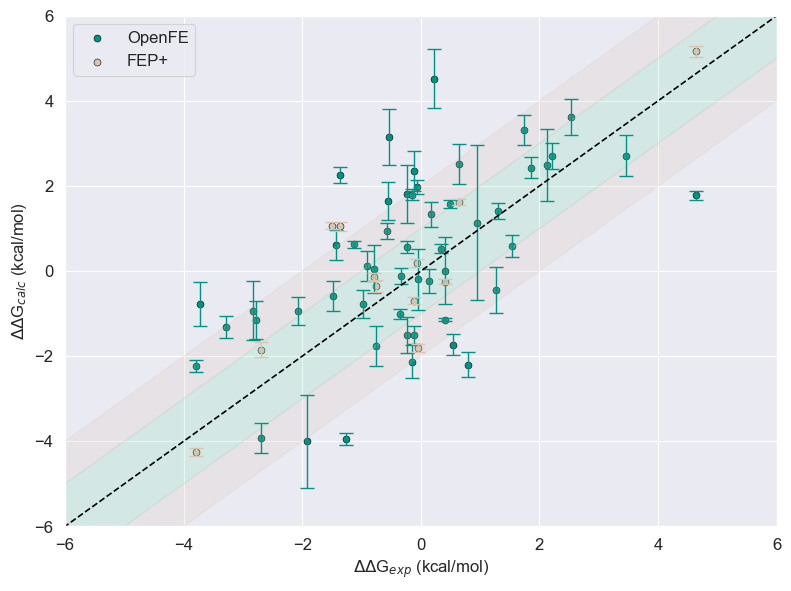

In [101]:
# plot the fused ring transformations vs experiment for OpenFE and FEP+ with error bars and colors by protocols
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_theme("paper")
# plot all openfe edges
complex_data = scaffold_change_df[[f"complex_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
complex_dg = complex_data.mean(axis=1)
solvent_data = scaffold_change_df[[f"solvent_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
solvent_dg = solvent_data.mean(axis=1)
openfe_ddg = complex_dg - solvent_dg
complex_error = complex_data.std(axis=1)
solvent_error = solvent_data.std(axis=1)
openfe_error = np.sqrt(complex_error**2 + solvent_error**2)
fep_plus_ddg = overlap_scaffold_change_df["FEP+ Bennett ddG (kcal/mol)"]
fep_plus_error = overlap_scaffold_change_df["FEP+ Bennett std. error (kcal/mol)"]
exp_ddg = scaffold_change_df["exp DDG (kcal/mol)"]
exp_error = scaffold_change_df["exp dDDG (kcal/mol)"]
exp_ddg_fep_plus = overlap_scaffold_change_df["exp DDG (kcal/mol)"]
exp_error_fep_plus = overlap_scaffold_change_df["exp dDDG (kcal/mol)"]
# calculate the RMSE and MUE for OpenFE and FEP+ for scaffold
# create a scatter plot with error bars
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=exp_ddg, y=openfe_ddg, ax=ax, color="#009384", label="OpenFE", s=25, edgecolor='black')
sns.scatterplot(x=exp_ddg_fep_plus, y=fep_plus_ddg, ax=ax, color="#d9c4b1", label="FEP+", s=25, edgecolor='black')
# add the error bars for OpenFE and FEP+
ax.errorbar(exp_ddg, openfe_ddg, 
            yerr=openfe_error, fmt='none', color="#009384", capsize=5, elinewidth=1, )
ax.errorbar(exp_ddg_fep_plus, fep_plus_ddg, 
            yerr=fep_plus_error, fmt='none', color="#d9c4b1", capsize=5, elinewidth=1, )
# add the error bars for the experimental values
# ax.errorbar(exp_ddg, exp_ddg, 
#             yerr=exp_error, fmt='none', color="black", capsize=5, elinewidth=1, label="Exp error")
# add a 45 degree line
max_val = max(exp_ddg.max(), openfe_ddg.max(), fep_plus_ddg.max())
min_val = min(exp_ddg.min(), openfe_ddg.min(), fep_plus_ddg.min())
ax.plot([min_val, max_val], [min_val, max_val], color="black", linestyle="--", )
# add a shadded region for the 1 kcal/mol error
ax.fill_between([min_val, max_val], [min_val - 1, max_val - 1], 
                [min_val + 1, max_val + 1], color="#7AE3B4", alpha=0.2, )
# add a shadded region between 1 and 2 kcal/mol error
ax.fill_between([min_val, max_val], [min_val - 2, max_val - 2], 
                [min_val - 1, max_val - 1], color="#d9c4b1", alpha=0.2, )
ax.fill_between([min_val, max_val], [min_val + 1, max_val + 1], 
                [min_val + 2, max_val + 2], color="#d9c4b1", alpha=0.2, )
# set the labels and title

# set the x and y limits    
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ax.set_xlabel(r"$\Delta\Delta$G$_{exp}$ (kcal/mol)", fontsize=12)
ax.set_ylabel(r"$\Delta\Delta$G$_{calc}$ (kcal/mol)", fontsize=12)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("fused_ring_transformations.png", dpi=300, bbox_inches='tight')


In [44]:
# function to automatically generate a pandas html report of the overlapping sets
# get the atom mapping exp openfe and FEP values and plot a bar chart to quickly look at the data and write to HTML
import base64
import numpy as np
def mol_to_html(interaction_image: str) -> str:
    raw_data = base64.b64encode(interaction_image.encode()).decode()
    return f"<img src='data:image/svg+xml;base64,{raw_data}'/>"

def create_overlap_report(df, fname):
    report_data = []
    for _, row in df.iterrows():
        system_name = row["system name"]
        system_group = row["system group"]
        liga = row["ligand_A"]
        ligb = row["ligand_B"]
        row_data = {"mapping": draw_mapping_karto(liga=liga, ligb=ligb, target=system_name, system=system_group), "Exp DDG (kcal/mol)": row["exp DDG (kcal/mol)"]}
        # workout the openfe estimate
        complex_data = [row[f"complex_repeat_{i}_DG (kcal/mol)"] for i in range(3)]
        complex_dg = np.mean(complex_data)
        complex_error = np.std(complex_data, ddof=1)
        solvent_data = [row[f"solvent_repeat_{i}_DG (kcal/mol)"] for i in range(3)]
        solvent_dg = np.mean(solvent_data)
        solvent_error = np.std(solvent_data, ddof=1)
        row_data["OpenFE DDG"] = complex_dg - solvent_dg
        row_data["OpenFE dDDG"] = (complex_error ** 2 + solvent_error ** 2) ** 0.5
        row_data["FEP+ Bennett DDG"] = row["FEP+ Bennett ddG (kcal/mol)"]
        row_data["FEP+ Bennett dDDG"] = row["FEP+ Bennett std. error (kcal/mol)"]
        row_data["system group"] = system_group
        row_data["system name"] = system_name
        report_data.append(row_data)
    report = pd.DataFrame(report_data)
    report.to_html(fname, escape=False, formatters={"mapping": mol_to_html})
    

In [45]:
create_overlap_report(overlap_scaffold_change_df, "overlap_scaffold_change_report.html")

In [ ]:
# create a report for the overlap edges from jacs set p38
p38_overlap_edges = overlap_df_final[(overlap_df_final["system group"] == "jacs_set") & (overlap_df_final["system name"] == "p38")].copy(deep=True).reset_index(drop=True)
create_overlap_report(p38_overlap_edges, "p38_overlap_edges.html")

In [ ]:
create_overlap_report(overlap_fep_plus_better, "fep_plus_better_edges.html")

In [ ]:
create_overlap_report(overlap_openfe_better, "overlap_openfe_better_report.html")

In [131]:
# load the bootstrap data
bootstrap_edges_openfe = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/combined_pymbar4_edge_data.csv")
rerun_bootstrap_openfe = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/reruns/rerun_pymbar4_edge_data.csv")
all_bootstrap_edges_openfe = bootstrap_edges_openfe[bootstrap_edges_openfe["system name"] != "pfkfb3"].copy(deep=True).reset_index(drop=True)
all_bootstrap_edges_openfe = pd.concat([all_bootstrap_edges_openfe, rerun_bootstrap_openfe]).reset_index(drop=True)
all_bootstrap_edges_openfe

,ligand_A,ligand_B,solvent_repeat_0_DG (kcal/mol),solvent_repeat_0_dDG (kcal/mol),solvent_repeat_0_smallest_overlap,solvent_repeat_1_DG (kcal/mol),solvent_repeat_1_dDG (kcal/mol),solvent_repeat_1_smallest_overlap,solvent_repeat_2_DG (kcal/mol),solvent_repeat_2_dDG (kcal/mol),...,complex_repeat_1_DG (kcal/mol),complex_repeat_1_dDG (kcal/mol),complex_repeat_1_smallest_overlap,complex_repeat_2_DG (kcal/mol),complex_repeat_2_dDG (kcal/mol),complex_repeat_2_smallest_overlap,partner_id,dataset_name,system group,system name
0,39charg,25,20.360247,0.477995,0.198963,20.390495,0.461825,0.200488,20.503254,0.483667,...,17.258927,0.779998,0.195608,17.934588,0.809891,0.198527,EliLilly,eli_lilly_charge/charge_annihilation_cdk2/resu...,charge_annihilation_set,cdk2
1,39charg,34,-18.515365,0.323653,0.197684,-18.401187,0.319921,0.196736,-18.425598,0.359356,...,-21.212537,0.461344,0.206534,-21.401634,0.579785,0.205918,EliLilly,eli_lilly_charge/charge_annihilation_cdk2/resu...,charge_annihilation_set,cdk2
2,34,25,26.902798,0.288979,0.141621,26.699658,0.327086,0.140087,26.756194,0.270871,...,27.472428,0.492906,0.111850,27.245596,0.513882,0.111561,EliLilly,eli_lilly_charge/charge_annihilation_cdk2/resu...,charge_annihilation_set,cdk2
3,9,4charg,-89.134348,0.462722,0.169842,-89.157175,0.439393,0.169260,-89.072765,0.420814,...,-88.072421,0.725085,0.171854,-88.127237,0.731602,0.171839,NaN,charge_annhil_dlk/charge_annhil_dlk/results_data,charge_annihilation_set,dlk
4,17charg,18,-86.775465,0.447984,0.194129,-86.691162,0.450044,0.193655,-86.800853,0.465490,...,-86.782652,0.714112,0.191229,-86.897203,0.912997,0.188960,NaN,charge_annhil_dlk/charge_annhil_dlk/results_data,charge_annihilation_set,dlk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140,"10302 (1GJ7, no water pose)",11417 (no water pose),-6.970065,0.247761,0.230715,-6.963792,0.242146,0.230504,-7.013646,0.249333,...,-4.931593,0.240233,0.232638,-4.857858,0.276601,0.232368,Janssen,janssen_public/waterset_urokinase/results_data,water_set,urokinase
1141,7806 (no water pose),8696 (no water pose),17.974265,0.051898,0.132659,17.981820,0.052770,0.132870,17.980524,0.050186,...,17.950910,0.057768,0.126303,17.930662,0.058544,0.126105,Janssen,janssen_public/waterset_urokinase/results_data,water_set,urokinase
1142,"10302 (1GJ7, no water pose)",8696 (no water pose),-7.745691,0.087072,0.126017,-7.657672,0.082068,0.125539,-7.651216,0.089154,...,-4.515525,0.059641,0.103170,-4.767291,0.065005,0.105011,Janssen,janssen_public/waterset_urokinase/results_data,water_set,urokinase
1143,47,46,-10.541877,0.074403,0.143176,-10.440122,0.080975,0.142742,-10.576783,0.081566,...,-11.105152,0.138236,0.133004,-11.214751,0.152255,0.132207,NaN,NaN,merck,pfkfb3


In [132]:
all_openfe_edges

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_1_ligand_rmsd_max,complex_repeat_1_smallest_overlap,complex_repeat_2_DG (kcal/mol),complex_repeat_2_dDG (kcal/mol),complex_repeat_2_com_drift_max,complex_repeat_2_ligand_rmsd_max,complex_repeat_2_smallest_overlap,failed,system group,system name
0,34,25,0.670320,0,1.000000,0.057515,0.966424,0.730672,25,2,...,28.411707,0.110235,27.245596,0.113900,3.984440,4.468362,0.111000,NaN,charge_annihilation_set,cdk2
1,39charg,34,0.000000,-1,0.614286,0.012182,0.980239,0.988664,27,0,...,32.545681,0.207117,-21.401634,0.074439,31.848991,32.294037,0.206549,NaN,charge_annihilation_set,cdk2
2,39charg,25,0.000000,-1,0.614286,0.045757,0.985675,0.724526,25,2,...,29.240601,0.198225,17.934588,0.088183,31.980310,32.360592,0.198287,NaN,charge_annihilation_set,cdk2
3,17charg,8,0.223130,0,1.000000,0.143513,0.445382,0.996009,19,9,...,4.466974,0.022621,-3.680717,0.204893,3.250983,4.278775,0.022991,NaN,charge_annihilation_set,dlk
4,4charg,8,0.246597,0,1.000000,0.048722,0.579467,1.000000,20,3,...,3.812082,0.138050,4.873596,0.068123,3.571454,4.066833,0.134652,NaN,charge_annihilation_set,dlk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,49,47,0.860708,0,1.000000,0.074540,0.937613,0.653421,28,0,...,68.239609,0.098195,5.025639,0.083096,47.049469,68.496689,0.104164,NaN,merck,pfkfb3
1177,65,29,0.704688,0,1.000000,0.155796,0.895401,0.484258,30,0,...,67.026726,0.157674,-83.240725,0.102459,29.012836,53.727703,0.160825,NaN,merck,pfkfb3
1178,29,64,0.778801,0,1.000000,0.155630,0.895401,0.462020,30,1,...,54.050873,0.165275,86.337561,0.101216,46.250511,68.017464,0.164021,NaN,merck,pfkfb3
1179,47,46,0.548812,0,1.000000,0.202290,0.735485,0.305883,27,2,...,52.765472,0.133457,-11.214751,0.046477,43.071308,66.045006,0.131496,NaN,merck,pfkfb3


In [133]:
# get all complex mbar errors and compare with the std between repeats and bootstrap errors
mbar_data = []
for system in all_openfe_edges["system group"].unique():
    system_df = all_openfe_edges[all_openfe_edges["system group"] == system].copy(deep=True).reset_index(drop=True)
    for target in system_df["system name"].unique():
        target_df = system_df[system_df["system name"] == target].copy(deep=True).reset_index(drop=True)
        bootstrap_target_df = all_bootstrap_edges_openfe[(all_bootstrap_edges_openfe["system group"] == system) & (all_bootstrap_edges_openfe["system name"] == target)]
        for _, row in target_df.iterrows():
            data = {
                "Standard error of repeates (kcal/mol)": np.std([row[f"complex_repeat_{i}_DG (kcal/mol)"] for i in range(3)], ddof=1),
                "Error type": "Analytical",
                "Error estimate (kcal/mol)": row["complex_repeat_0_dDG (kcal/mol)"]
            }
            # get the bootstrap data
            boot_row = bootstrap_target_df[(bootstrap_target_df["ligand_A"] == row["ligand_A"]) & (bootstrap_target_df["ligand_B"] == row["ligand_B"])]
            if len(boot_row) == 1:
                data_boot = {
                    "Standard error of repeates (kcal/mol)": np.std([row[f"complex_repeat_{i}_DG (kcal/mol)"] for i in range(3)], ddof=1),
                    "Error type": "Bootstrap",
                    "Error estimate (kcal/mol)": boot_row.iloc[0]["complex_repeat_0_dDG (kcal/mol)"]
                }
                mbar_data.extend([data, data_boot])

pd.DataFrame(mbar_data)

,Standard error of repeates (kcal/mol),Error type,Error estimate (kcal/mol)
0,0.231123,Analytical,0.094220
1,0.231123,Bootstrap,0.477337
2,0.236961,Analytical,0.083551
3,0.236961,Bootstrap,0.641610
4,0.346987,Analytical,0.113683
...,...,...,...
2247,0.126607,Bootstrap,0.052336
2248,0.017092,Analytical,0.027507
2249,0.017092,Bootstrap,0.053998
2250,0.095470,Analytical,0.035642


In [134]:
pd.DataFrame(mbar_data).sort_values("Error estimate (kcal/mol)")

,Standard error of repeates (kcal/mol),Error type,Error estimate (kcal/mol)
2122,0.015830,Analytical,0.010017
820,0.237723,Analytical,0.010461
826,0.106985,Analytical,0.010510
821,0.237723,Bootstrap,0.012045
1960,0.023257,Analytical,0.012099
...,...,...,...
1437,1.743982,Bootstrap,2.488849
1401,0.292986,Bootstrap,2.630991
1439,1.600129,Bootstrap,2.913553
1769,0.748823,Bootstrap,3.066983


Analytical R^2: 0.274
Bootstrap R^2: 0.207


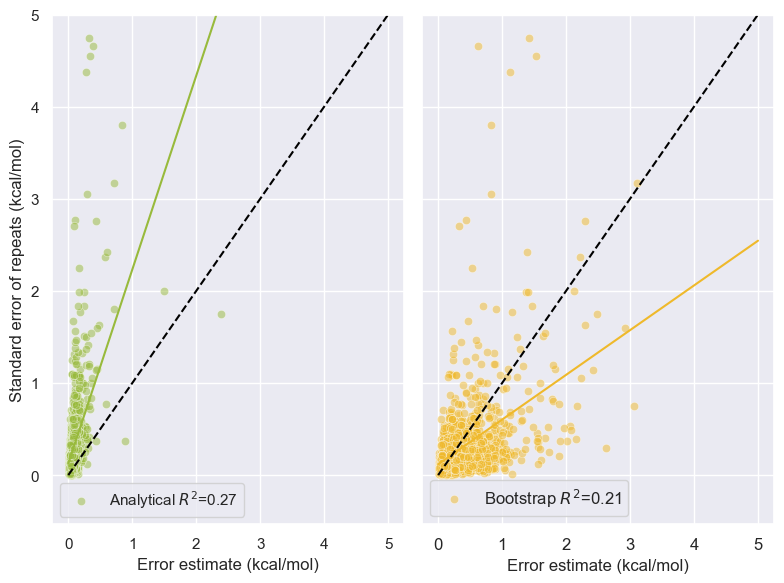

In [155]:
# scatter plot of the errors on two subplots
from scipy import stats
fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharey=True)
mbar_data = pd.DataFrame(mbar_data)
analytical_data = mbar_data[mbar_data["Error type"] == "Analytical"].copy(deep=True)
bootstrap_data = mbar_data[mbar_data["Error type"] == "Bootstrap"]
# calculate the correlation coefficient
slope, intercept, r_value, p_value, std_err = stats.linregress(analytical_data["Error estimate (kcal/mol)"].values, analytical_data["Standard error of repeates (kcal/mol)"].values)
print(f"Analytical R^2: {r_value**2:.3f}")
sns.scatterplot(y=analytical_data["Standard error of repeates (kcal/mol)"].values, x=analytical_data["Error estimate (kcal/mol)"].values, label=r"Analytical $R^{2}$=0.27", alpha=0.5, ax=ax[0], color="#98BA3C")
# plot the line of best fit
x = np.linspace(0, 5, 100)
y = slope * x + intercept
ax[0].plot(x, y, color="#98BA3C", linestyle="-")
slope, intercept, r_value, p_value, std_err = stats.linregress(bootstrap_data["Error estimate (kcal/mol)"].values, bootstrap_data["Standard error of repeates (kcal/mol)"].values)
print(f"Bootstrap R^2: {r_value**2:.3f}")
sns.scatterplot(y=bootstrap_data["Standard error of repeates (kcal/mol)"].values, x=bootstrap_data["Error estimate (kcal/mol)"].values, label=r"Bootstrap $R^{2}$=0.21", alpha=0.5, ax=ax[1], color="#EFB92B")
# plot the line of best fit
x = np.linspace(0, 5, 100)
y = slope * x + intercept
ax[1].plot(x, y, color="#EFB92B", linestyle="-")
ax[0].plot([0, 5], [0, 5], color="black", linestyle="--")
ax[1].plot([0, 5], [0, 5], color="black", linestyle="--")
ax[0].set_xlabel("Error estimate (kcal/mol)", fontdict={"fontsize": 12})
ax[1].set_xlabel("Error estimate (kcal/mol)", fontdict={"fontsize": 12})
ax[0].set_ylabel("Standard error of repeats (kcal/mol)", fontdict={"fontsize": 12})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim( top=5)
plt.tight_layout()
plt.legend(fontsize=12)
plt.savefig("mbar_error_analysis.png", dpi=300, bbox_inches='tight')

In [ ]:
# compre the overlap from mbar with the absolute edge error
exp_ddg = variable_edges["exp DDG (kcal/mol)"]
exp_error = variable_edges["exp dDDG (kcal/mol)"]
# calculate the DDG using the std between repeats as the error
complex_data = variable_edges[[f"complex_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
complex_dg = complex_data.mean(axis=1)
complex_error = complex_data.std(axis=1)
solvent_data = variable_edges[[f"solvent_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
solvent_dg = solvent_data.mean(axis=1)
solvent_error = solvent_data.std(axis=1)
mean_ddg = complex_dg - solvent_dg
ddg_error = (complex_error ** 2 + solvent_error ** 2) ** 0.5
abs_mean_error = abs(mean_ddg - exp_ddg)
# repeat 0 
ddg_0 = variable_edges["complex_repeat_2_DG (kcal/mol)"] - variable_edges["solvent_repeat_2_DG (kcal/mol)"]
mean_0_abs_error =  abs(ddg_0 - exp_ddg)
